<a href="https://colab.research.google.com/github/doaa450/Customer-lifetime-value/blob/main/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
import sklearn
print("Scikit-learn version:", sklearn.__version__)

Scikit-learn version: 1.5.2


In [3]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import math
import shap
# load JS visualization code to notebook
shap.initjs()
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Investigation and Cleaning


## Data Investigation

In [4]:
# Loading the Dataset
df = pd.read_excel('/content/Online Retail.xlsx')

In [5]:
# Dataset Overview
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541909.0,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


In [8]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


## Data Cleaning

In [9]:
# Delete incomplete data
df=df[df['InvoiceDate']<'2011-12-01']

Handling Missing Values

In [10]:
# Check for null values in each column
null_values = df.isnull().sum()
# Display columns with null values and their counts
print("Columns with Null Values:")
print(null_values[null_values > 0])

Columns with Null Values:
Description      1439
CustomerID     127216
dtype: int64


In [11]:
# Drop rows with null values
df = df.dropna()

In [12]:
# Verifying the removal of missing values
df.isnull().sum().sum()

np.int64(0)

Handling Duplicates

In [13]:
# Finding duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom


In [14]:
df.duplicated().sum()

np.int64(4946)

In [15]:
# Removing duplicate rows
df.drop_duplicates(inplace=True)

In [16]:
# Getting the number of rows in the dataframe
df.shape[0]

384222

Treating Cancelled Transactions

In [17]:
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

In [18]:
df['Transaction_Status'].value_counts()

,count
Transaction_Status,
Completed,375706
Cancelled,8516


Treating Unit Prices

In [19]:
df[df['UnitPrice']==0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,Completed
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,Completed
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,Completed
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,Completed
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,Completed


In [20]:
df[df['UnitPrice']==0].describe()['Quantity']

,Quantity
count,40.000000
mean,347.100000
min,1.000000
25%,1.000000
50%,4.500000
75%,24.000000
max,12540.000000
std,1978.311813


In [21]:
# Removing records with a unit price of zero
df = df[df['UnitPrice'] > 0]

In [22]:
# Resetting the index
df.reset_index(drop=True, inplace=True)

In [23]:
# Getting the number of rows
df.shape[0]

384182

# Data Analysis & Feature Engineering


In [24]:
df.drop(['StockCode'],axis=1,inplace=True)

In [25]:
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

In [26]:
# Date Time Analysis
df["Month"] = df.InvoiceDate.dt.month
df["Year"] = df.InvoiceDate.dt.year
df["Day"] = df.InvoiceDate.dt.day
df["Hour"] = df.InvoiceDate.dt.hour
df["Quarter"] = df.InvoiceDate.dt.quarter
df["Day of Week"] = df.InvoiceDate.dt.dayofweek

In [27]:
#Mapping day of week
dayofweek_mapping = dict({0: "Monday",
                         1: "Tuesday",
                         2: "Wednesday" ,
                         3: "Thursday",
                         4: "Friday",
                         5: "Saturday",
                         6: "Sunday"})

In [28]:
df["Day of Week"] = df["Day of Week"].map(dayofweek_mapping)

In [29]:
df.head(3)

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status,Total_Price,Month,Year,Day,Hour,Quarter,Day of Week
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,15.30,12,2010,1,8,4,Wednesday
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,20.34,12,2010,1,8,4,Wednesday
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,22.00,12,2010,1,8,4,Wednesday


Best 10 Products

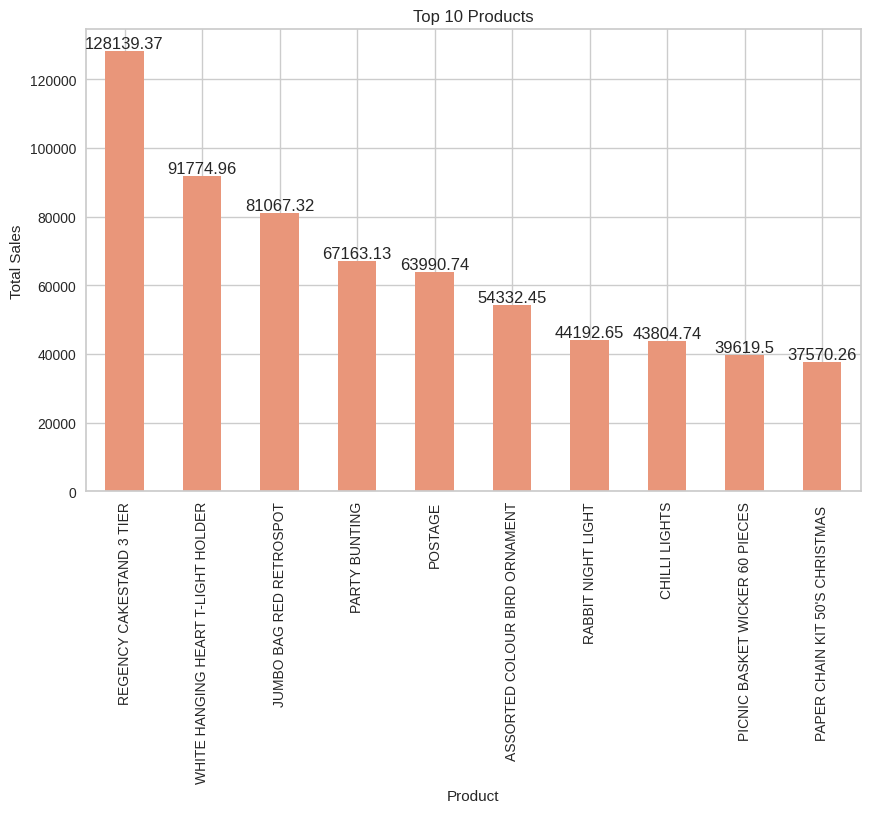

In [30]:
Top_sales_data = df.groupby(['Description'])['Total_Price'].sum().sort_values(ascending=False).head(10)

# Plotting
ax = Top_sales_data.plot(kind='bar', color='darksalmon', figsize=(10, 6))
plt.title('Top 10 Products')
plt.xlabel('Product')
plt.ylabel('Total Sales')

# Displaying sales values on top of each bar
for idx, value in enumerate(Top_sales_data):
    ax.text(idx, value + 0.5, str(round(value, 2)), ha='center', va='bottom', rotation=0)

plt.show()

In [31]:
Top_sales_data

,Total_Price
Description,
REGENCY CAKESTAND 3 TIER,128139.37
WHITE HANGING HEART T-LIGHT HOLDER,91774.96
JUMBO BAG RED RETROSPOT,81067.32
PARTY BUNTING,67163.13
POSTAGE,63990.74
ASSORTED COLOUR BIRD ORNAMENT,54332.45
RABBIT NIGHT LIGHT,44192.65
CHILLI LIGHTS,43804.74
PICNIC BASKET WICKER 60 PIECES,39619.50


Best 5 Countries for sales

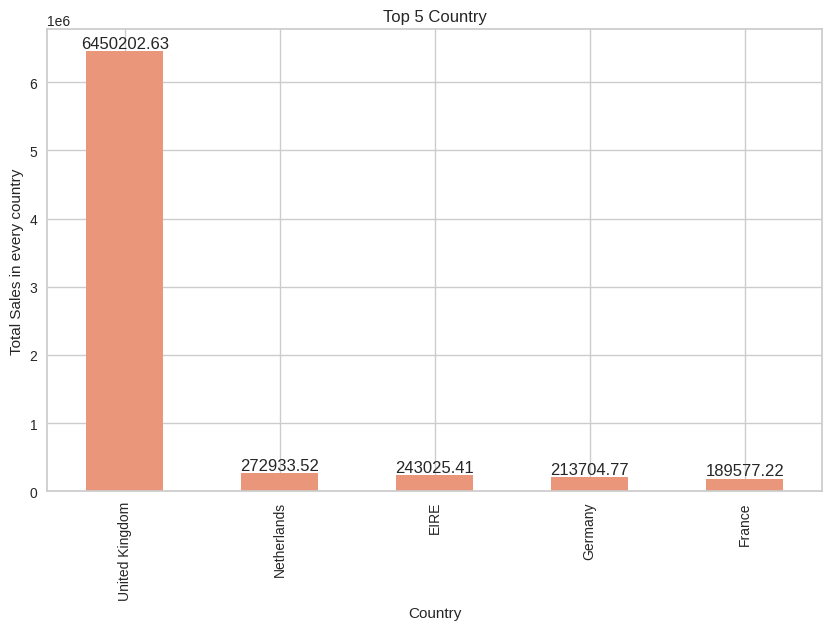

In [32]:
Top_sales_by_country = df.groupby(['Country'])['Total_Price'].sum().sort_values(ascending=False).head(5)

# Plotting
ax = Top_sales_by_country.plot(kind='bar', color='darksalmon', figsize=(10, 6))
plt.title('Top 5 Country')
plt.xlabel('Country')
plt.ylabel('Total Sales in every country')

# Displaying sales values on top of each bar
for idx, value in enumerate(Top_sales_by_country):
    ax.text(idx, value + 0.5, str(round(value, 2)), ha='center', va='bottom', rotation=0)

plt.show()

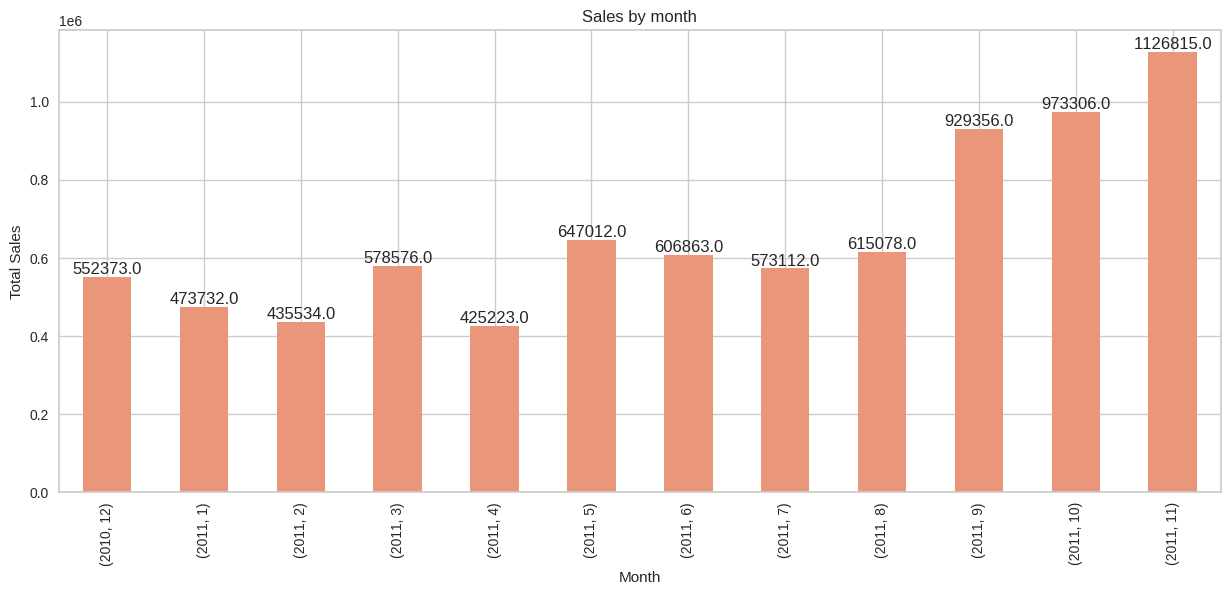

In [33]:
sales_data_Month = df.groupby(['Year','Month'])['Total_Price'].sum()

# Plotting
ax = sales_data_Month.plot(kind='bar', color='darksalmon', figsize=(15, 6))
plt.title('Sales by month')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Displaying sales values on top of each bar
for idx, value in enumerate(sales_data_Month):
    ax.text(idx, value + 0.5, str(round(value, 0)), ha='center', va='bottom', rotation=0)

plt.show()

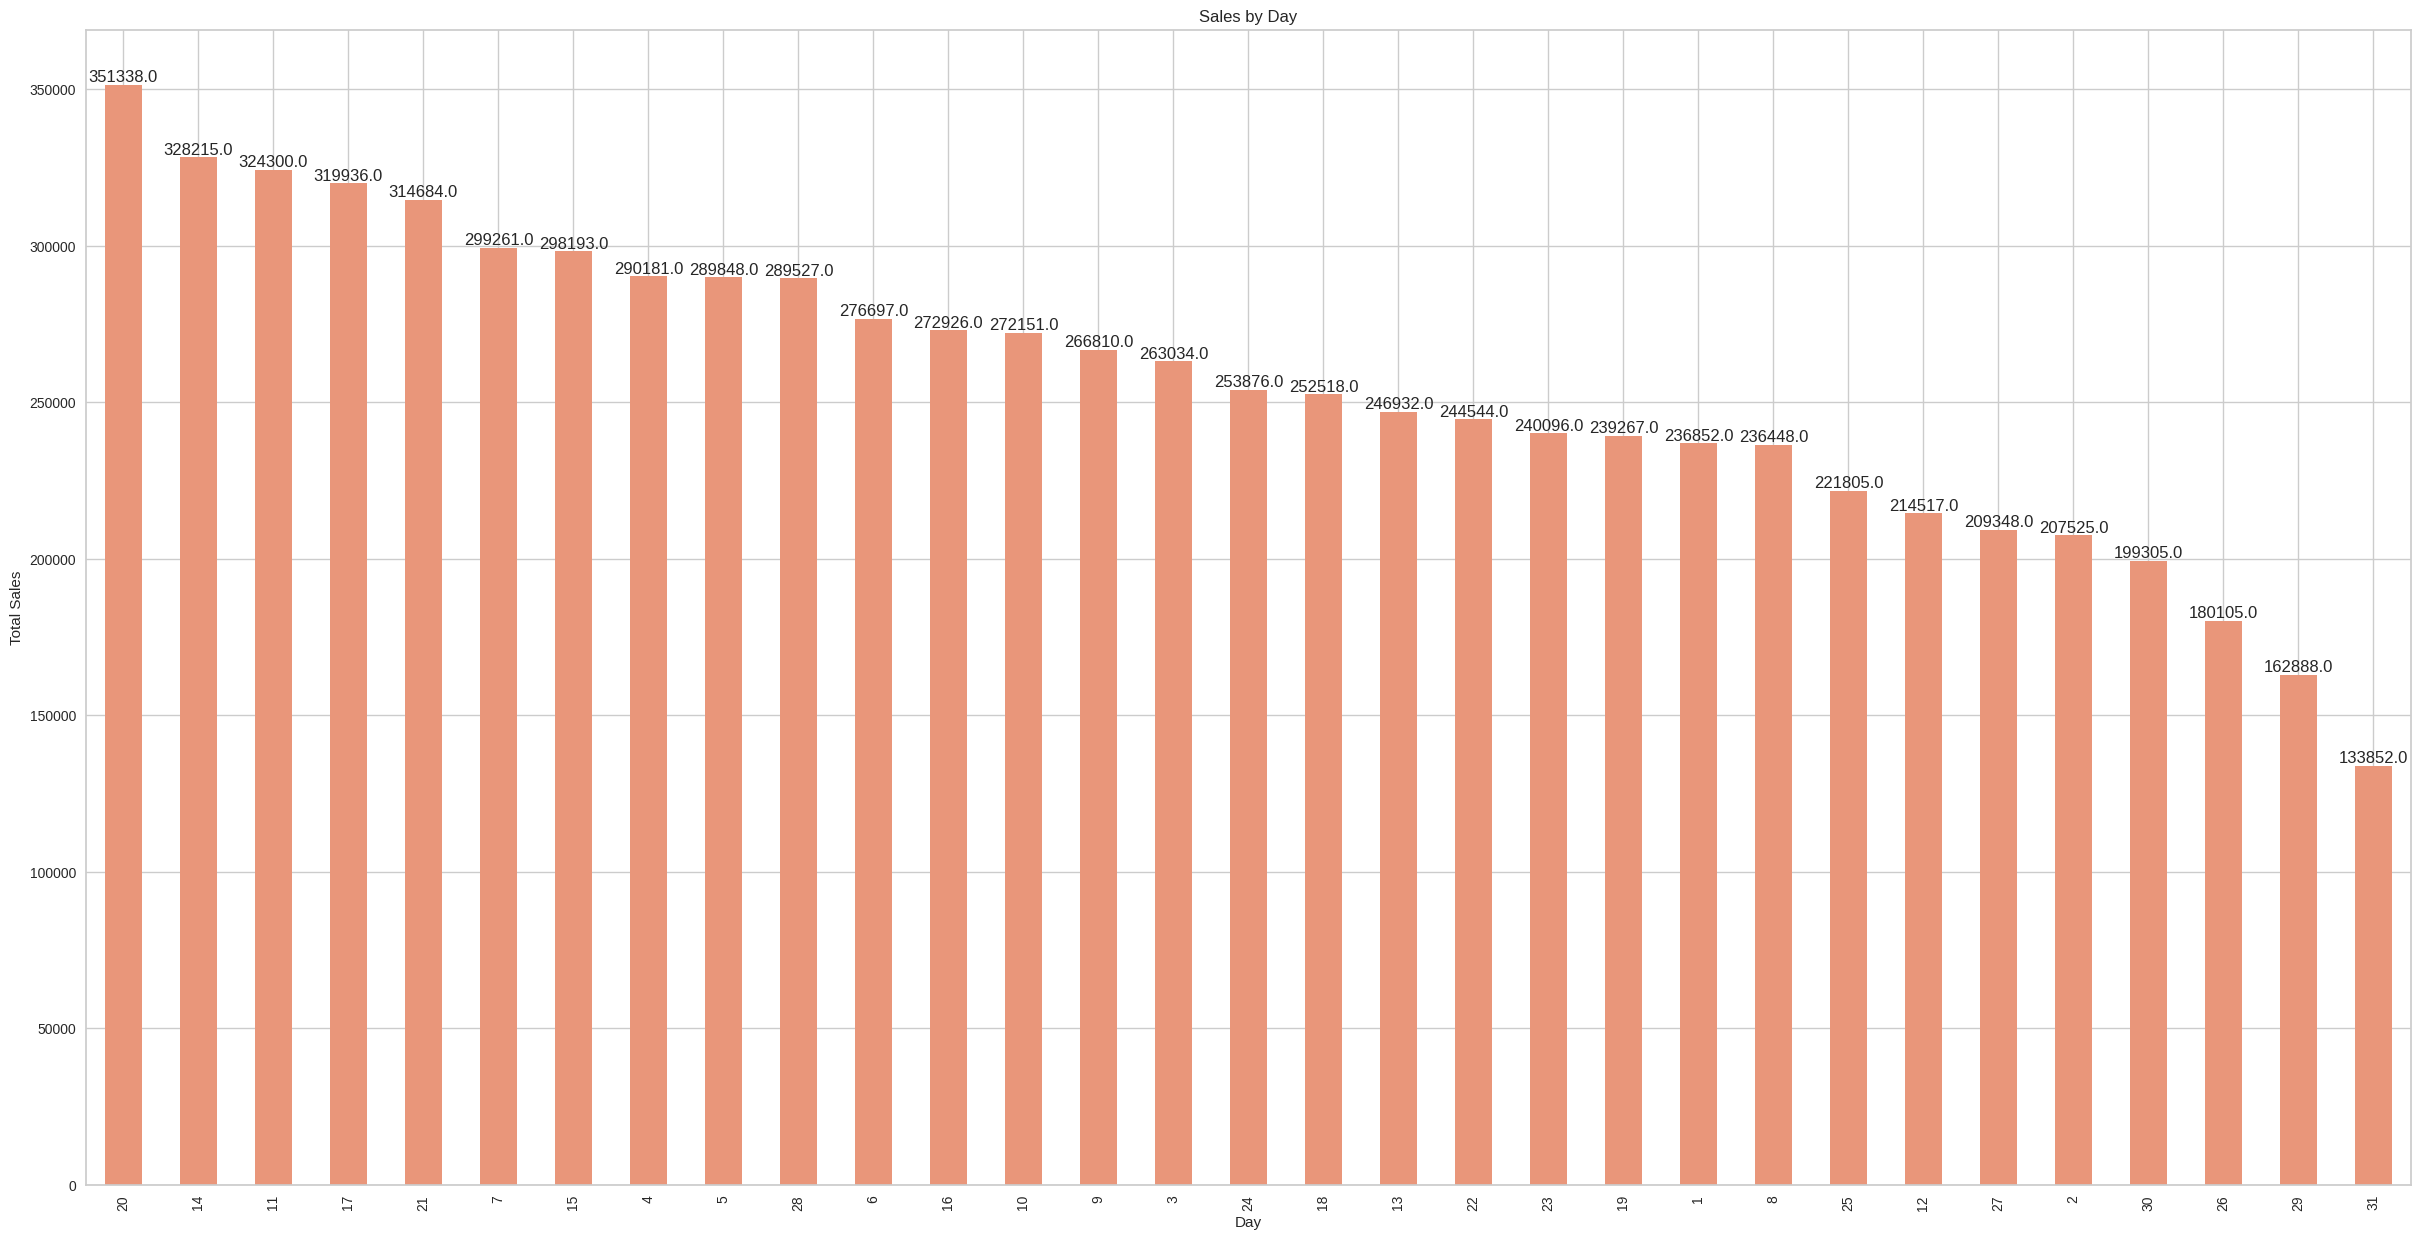

In [34]:
sales_data_day = df.groupby(['Day'])['Total_Price'].sum().sort_values(ascending=False)

# Plotting
ax = sales_data_day.plot(kind='bar', color='darksalmon', figsize=(30, 15))
plt.title('Sales by Day')
plt.xlabel('Day')
plt.ylabel('Total Sales')

# Displaying sales values on top of each bar
for idx, value in enumerate(sales_data_day):
    ax.text(idx, value + 0.5, str(round(value, 0)), ha='center', va='bottom', rotation=0)

plt.show()

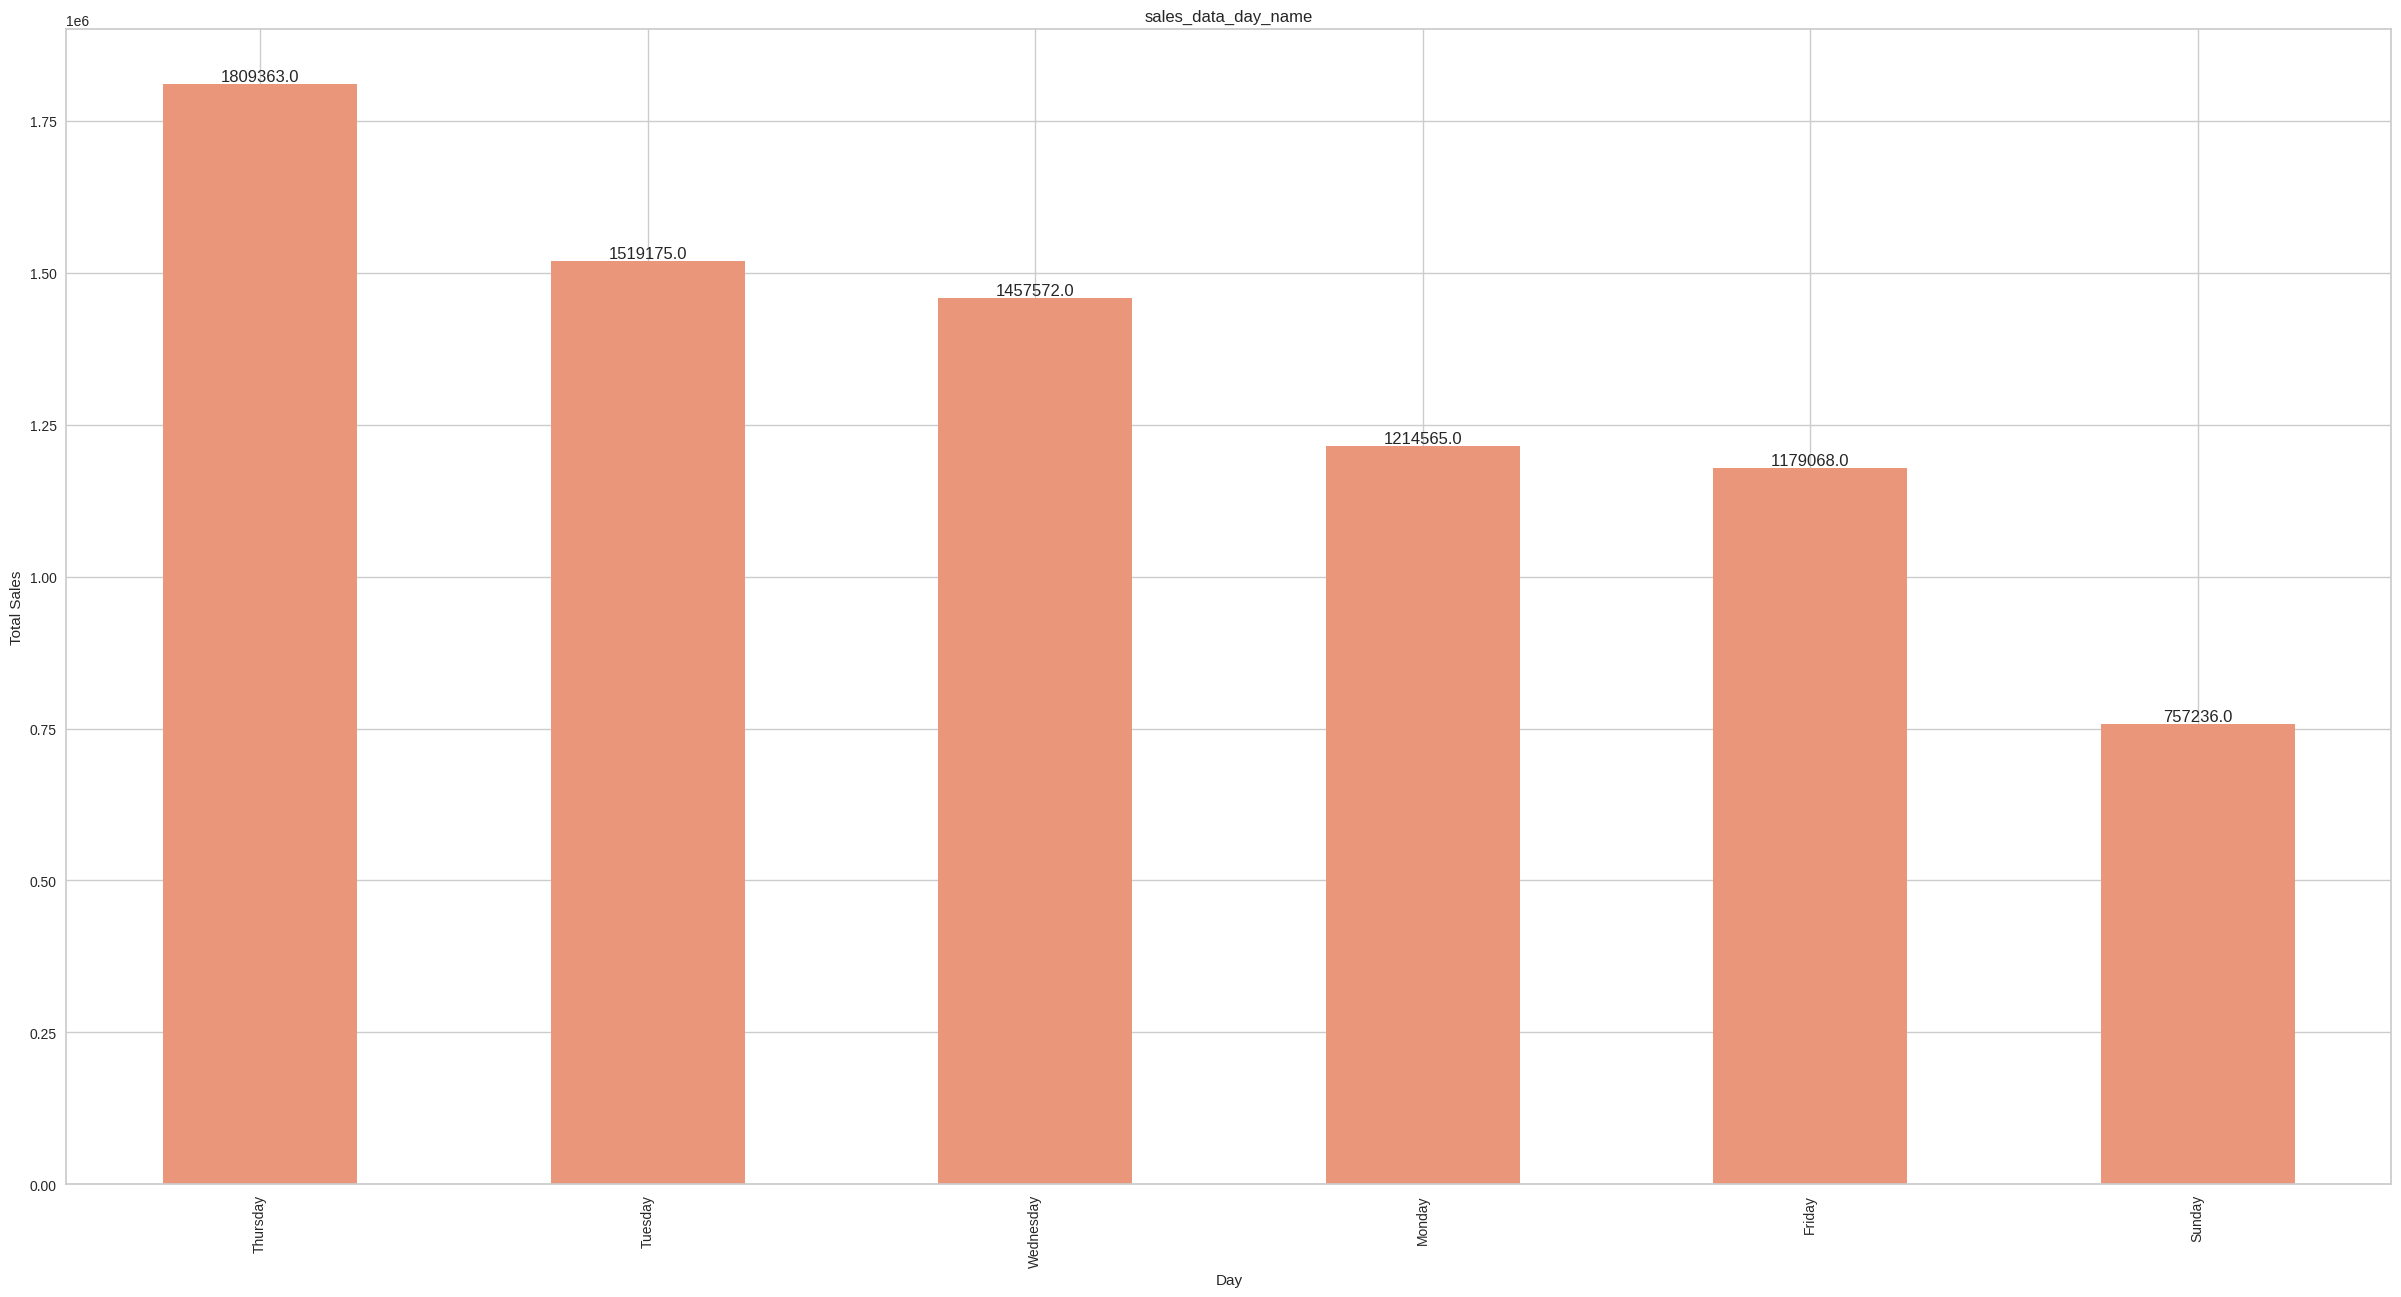

In [35]:
sales_data_day_name = df.groupby(['Day of Week'])['Total_Price'].sum().sort_values(ascending=False)

# Plotting
ax = sales_data_day_name.plot(kind='bar', color='darksalmon', figsize=(30, 15))
plt.title('sales_data_day_name')
plt.xlabel('Day')
plt.ylabel('Total Sales')

# Displaying sales values on top of each bar
for idx, value in enumerate(sales_data_day_name):
    ax.text(idx, value + 0.5, str(round(value, 0)), ha='center', va='bottom', rotation=0)

plt.show()

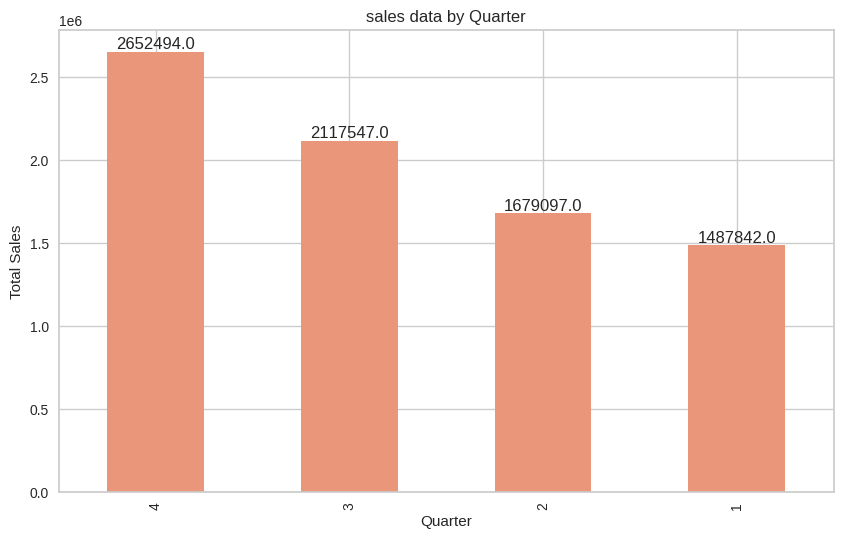

In [36]:
sales_data_Quarter = df.groupby(['Quarter'])['Total_Price'].sum().sort_values(ascending=False)

# Plotting
ax = sales_data_Quarter.plot(kind='bar', color='darksalmon', figsize=(10, 6))
plt.title('sales data by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')

# Displaying sales values on top of each bar
for idx, value in enumerate(sales_data_Quarter):
    ax.text(idx, value + 0.5, str(round(value, 0)), ha='center', va='bottom', rotation=0)

plt.show()

### Monthly Active Customers

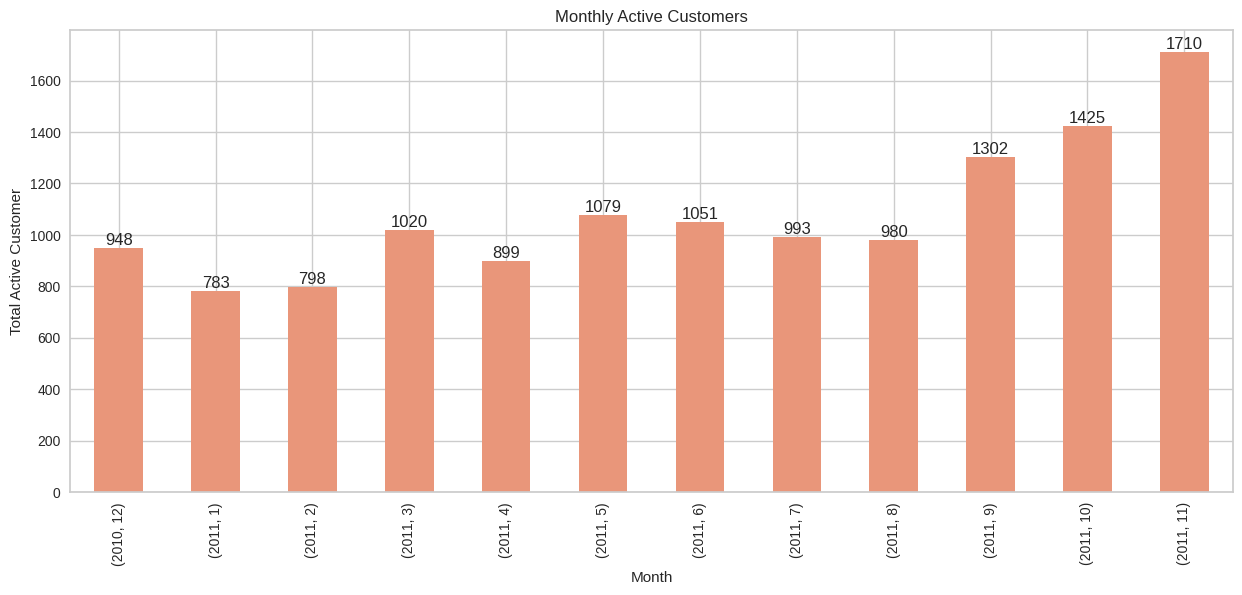

In [37]:
Monthly_Active_Customers = df.groupby(['Year','Month'])['CustomerID'].nunique()

# Plotting
ax = Monthly_Active_Customers.plot(kind='bar', color='darksalmon', figsize=(15, 6))
plt.title('Monthly Active Customers')
plt.xlabel('Month')
plt.ylabel('Total Active Customer')

# Displaying sales values on top of each bar
for idx, value in enumerate(Monthly_Active_Customers):
    ax.text(idx, value + 0.5, str(round(value, 0)), ha='center', va='bottom', rotation=0)

plt.show()

#### New Customer Ratio

In [38]:
cus_min_purchase = df.groupby('CustomerID').InvoiceDate.min().reset_index()

In [39]:
cus_min_purchase.columns = ['CustomerID','MinPurchaseDate']
cus_min_purchase['MinPurchaseYearMonth'] = cus_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [40]:
df = pd.merge(df, cus_min_purchase, on='CustomerID')

In [41]:
df['UserType'] = 'New'
df.loc[df['InvoiceYearMonth']>df['MinPurchaseYearMonth'],'UserType'] = 'Existing'

In [42]:
df['UserType'].value_counts()

,count
UserType,
Existing,267877
New,116305


In [43]:
cus_type_revenue = df.groupby(['InvoiceYearMonth','UserType'])['Total_Price'].sum().reset_index()

In [44]:
cus_type_revenue=cus_type_revenue.query("InvoiceYearMonth !=  201012")

In [45]:
cus_type_revenue['InvoiceYearMonth'] = cus_type_revenue['InvoiceYearMonth'].astype('int64')

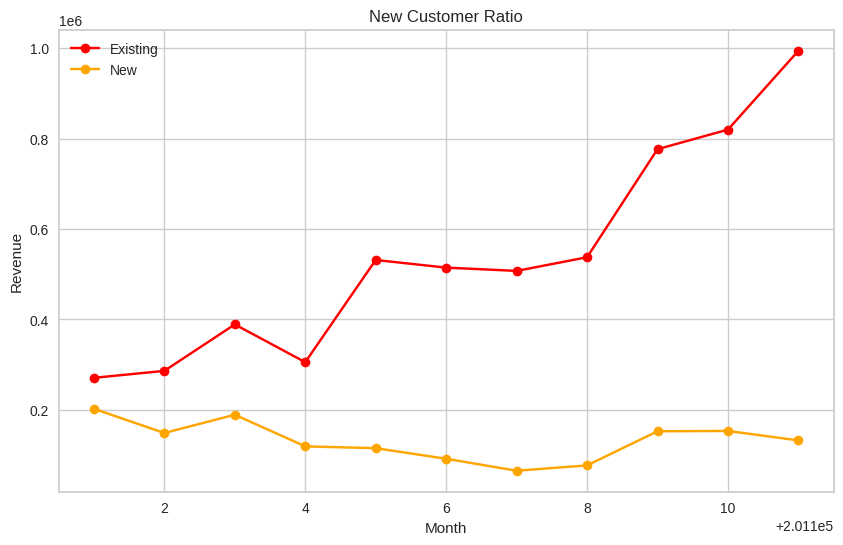

In [46]:
x_1=cus_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth']
y_1=cus_type_revenue.query("UserType == 'Existing'")['Total_Price']
#x_2=cus_type_revenue.query("UserType == 'New'")['InvoiceYearMonth']
y_2=cus_type_revenue.query("UserType == 'New'")['Total_Price']
plt.figure(figsize=(10,6))
plt.plot(x_1,y_1,marker='o',label='Existing',color='red')
plt.plot(x_1,y_2,marker='o',label='New',color='orange')
plt.title('New Customer Ratio')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.show()

## Xgboost Regression& Shape


**For building Xgboost model to predict ClTV we will make some steps as follow:**


- Set Data

        Step_1: Subet a cohort

        Step_2 : Temporal Spliiting

- Feature Engineering

      Step_3 : RFM features

      Step_4: numer of products

      Step_5: Cancellation_Frequency& Cancellation_Rate

      Step_6: Prediction model

      Step_7: Shap Value

### Step_1: Subet a cohort


In [47]:
df=df[df['Country']=='United Kingdom']
df.drop(['Country'],axis=1,inplace=True)

In [48]:
# Step_1: Subet a cohort (A cohort is a group of customers that all at the same time)
# only the customers that have joined at the business spesific day
df_first_purchase=df.sort_values(['CustomerID','InvoiceDate']).groupby('CustomerID').first()
df_first_purchase.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Transaction_Status,Total_Price,Month,Year,Day,Hour,Quarter,Day of Week,InvoiceYearMonth,MinPurchaseDate,MinPurchaseYearMonth,UserType
CustomerID,,,,,,,,,,,,,,,,,
12346.0,541431,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,Completed,77183.60,1,2011,18,10,1,Tuesday,201101,2011-01-18 10:01:00,201101,New
12747.0,537215,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,Completed,30.60,12,2010,5,15,4,Sunday,201012,2010-12-05 15:38:00,201012,New
12748.0,536521,CREAM SWEETHEART EGG HOLDER,1,2010-12-01 12:48:00,4.95,Completed,4.95,12,2010,1,12,4,Wednesday,201012,2010-12-01 12:48:00,201012,New
12749.0,552694,FAMILY PHOTO FRAME CORNICE,2,2011-05-10 15:25:00,9.95,Completed,19.90,5,2011,10,15,2,Tuesday,201105,2011-05-10 15:25:00,201105,New
12820.0,541283,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-01-17 12:34:00,0.55,Completed,13.20,1,2011,17,12,1,Monday,201101,2011-01-17 12:34:00,201101,New


In [49]:
df_first_purchase['InvoiceDate'].describe()

,InvoiceDate
count,3915
mean,2011-04-26 02:32:08.061302784
min,2010-12-01 08:26:00
25%,2011-01-11 12:43:30
50%,2011-03-30 13:56:00
75%,2011-08-10 12:34:00
max,2011-11-30 14:52:00


In [50]:
df_first_purchase=df_first_purchase[df_first_purchase['InvoiceDate']<'2011-03-01']

In [51]:
df_first_purchase['InvoiceDate'].min(),df_first_purchase['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-02-28 17:01:00'))

In [52]:
df_first_purchase=df_first_purchase.reset_index()

In [53]:
len(df_first_purchase)

1572

In [54]:
ids=df_first_purchase['CustomerID']

In [55]:
cohort_df=df[df['CustomerID'].isin(ids)]

In [56]:
len(cohort_df)

215062

In [57]:
cohort_df['InvoiceDate'].min(),cohort_df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-11-30 17:42:00'))

### Step_2 : Temporal Spliiting


In [58]:
Training_df=cohort_df[cohort_df['InvoiceDate']<'2011-09-01']

In [59]:
Test_df=cohort_df[cohort_df['InvoiceDate']>'2011-09-01']


In [60]:
Training_df['InvoiceDate'].min(),Training_df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-08-31 17:45:00'))

In [61]:
Test_df['InvoiceDate'].min(),Test_df['InvoiceDate'].max()

(Timestamp('2011-09-01 08:25:00'), Timestamp('2011-11-30 17:42:00'))

In [62]:
Training_df['CustomerID'].nunique(),Test_df['CustomerID'].nunique()

(1572, 992)

In [63]:
outTable = Test_df.groupby('CustomerID')['Total_Price'].sum().reset_index().rename({'Total_Price':'Total_Sales_3M'},axis=1)

In [64]:
outTable.head()

,CustomerID,Total_Sales_3M
0,12747.0,988.11
1,12748.0,14534.29
2,12820.0,561.53
3,12823.0,535.50
4,12826.0,513.50


### step_3 : RFM features


In [65]:
import datetime as dt
PRESENT = dt.datetime(2011,8,31)

RFM Analysis

Here, you are going to perform following opertaions:

    For Recency, Calculate the number of days between present date and date of last purchase each customer.
    For Frequency, Calculate the number of orders for each customer.
    For Monetary, Calculate sum of purchase price for each customer.


In [66]:
rfmTable = Training_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (PRESENT - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'Total_Price': ['sum', 'min', 'max','mean','std'],  # Monetary (sum, min, max,mean,std)
    'Quantity': 'sum'
})

rfmTable.columns = ['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Min', 'Monetary_Max','Monetary_Mean','Monetary_std','Quantity']

# Convert Recency to integer
rfmTable['Recency'] = rfmTable['Recency'].astype(int)

In [67]:
rfmTable.reset_index(inplace = True)

In [68]:
rfmTable.head()

,CustomerID,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity
0,12346.0,224,2,0.00,-77183.60,77183.6,0.000000,109154.093913,0
1,12747.0,8,70,2769.40,10.20,199.8,39.562857,42.643523,862
2,12748.0,0,1944,12872.27,-179.00,400.0,6.621538,15.435534,8092
3,12820.0,225,11,170.46,6.96,19.8,15.496364,4.205490,146
4,12823.0,26,4,1224.00,229.50,459.0,306.000000,108.187338,160


In [69]:


rfmTable["RecencyScore"] = pd.qcut(rfmTable["Recency"], 5, labels = [5, 4 , 3, 2, 1])

rfmTable["FrequencyScore"]= pd.qcut(rfmTable["Frequency"].rank(method="first"),5, labels=[1,2,3,4,5])

rfmTable["MonetaryScore"] = pd.qcut(rfmTable['Monetary_Sum'], 5, labels = [1, 2, 3, 4, 5])

rfmTable.head()



,CustomerID,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore
0,12346.0,224,2,0.00,-77183.60,77183.6,0.000000,109154.093913,0,1,1,1
1,12747.0,8,70,2769.40,10.20,199.8,39.562857,42.643523,862,5,4,5
2,12748.0,0,1944,12872.27,-179.00,400.0,6.621538,15.435534,8092,5,5,5
3,12820.0,225,11,170.46,6.96,19.8,15.496364,4.205490,146,1,1,1
4,12823.0,26,4,1224.00,229.50,459.0,306.000000,108.187338,160,4,1,4


In [70]:
rfmTable["RFM_SCORE"] = (rfmTable['RecencyScore'].astype(str) +
                     rfmTable['FrequencyScore'].astype(str) +
                     rfmTable['MonetaryScore'].astype(str))
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfmTable['Segment'] = rfmTable['RecencyScore'].astype(str) + rfmTable['FrequencyScore'].astype(str)

rfmTable['Segment'] = rfmTable['Segment'].replace(seg_map, regex=True)


In [71]:
rfmTable.head()

,CustomerID,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
0,12346.0,224,2,0.00,-77183.60,77183.6,0.000000,109154.093913,0,1,1,1,111,Hibernating
1,12747.0,8,70,2769.40,10.20,199.8,39.562857,42.643523,862,5,4,5,545,Champions
2,12748.0,0,1944,12872.27,-179.00,400.0,6.621538,15.435534,8092,5,5,5,555,Champions
3,12820.0,225,11,170.46,6.96,19.8,15.496364,4.205490,146,1,1,1,111,Hibernating
4,12823.0,26,4,1224.00,229.50,459.0,306.000000,108.187338,160,4,1,4,414,Promising


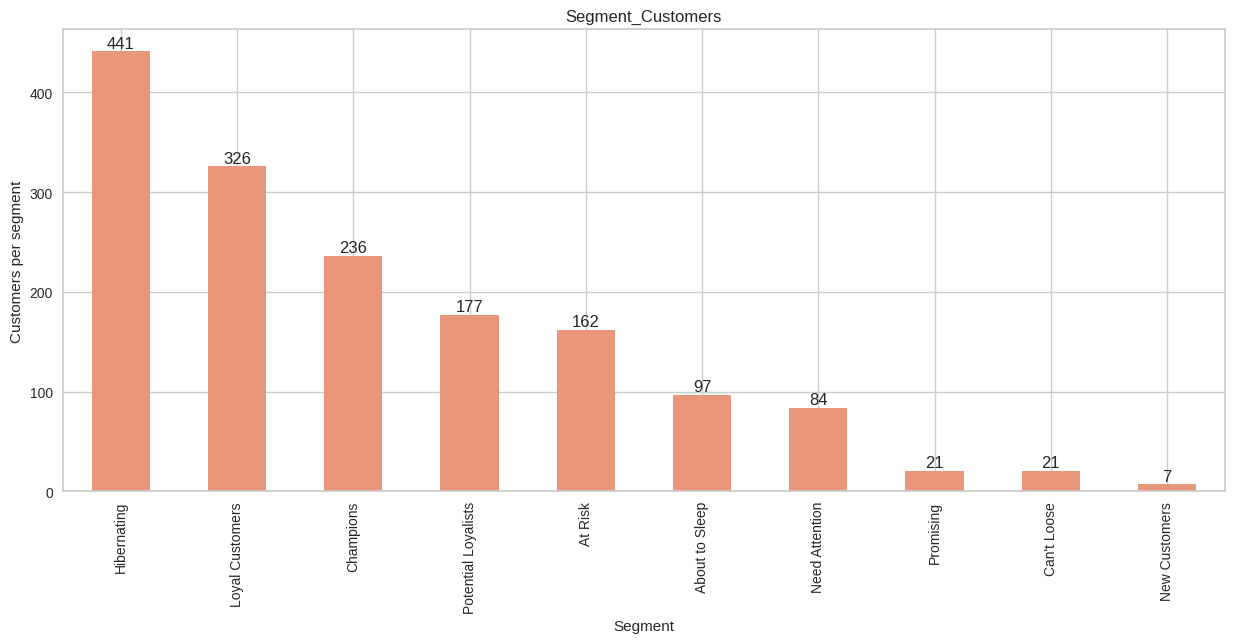

In [72]:
Segment_Customers =rfmTable['Segment'].value_counts()

# Plotting
ax = Segment_Customers.plot(kind='bar', color='darksalmon', figsize=(15, 6))
plt.title('Segment_Customers')
plt.xlabel('Segment')
plt.ylabel('Customers per segment')

# Displaying sales values on top of each bar
for idx, value in enumerate(Segment_Customers):
    ax.text(idx, value + 0.5, str(round(value, 0)), ha='center', va='bottom', rotation=0)

In [73]:
seg_percent=pd.DataFrame(rfmTable['Segment'].value_counts())
seg_percent['perc']= (seg_percent['count']/seg_percent['count'].sum())*100

In [74]:
seg_percent

,count,perc
Segment,,
Hibernating,441,28.053435
Loyal Customers,326,20.737913
Champions,236,15.012723
Potential Loyalists,177,11.259542
At Risk,162,10.305344
About to Sleep,97,6.170483
Need Attention,84,5.343511
Promising,21,1.335878
Can't Loose,21,1.335878


### Step_4: numer of products

In [75]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = Training_df.groupby('CustomerID')['Description'].nunique().reset_index()
unique_products_purchased.rename(columns={'Description': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(rfmTable, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()



,CustomerID,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment,Unique_Products_Purchased
0,12346.0,224,2,0.00,-77183.60,77183.6,0.000000,109154.093913,0,1,1,1,111,Hibernating,1
1,12747.0,8,70,2769.40,10.20,199.8,39.562857,42.643523,862,5,4,5,545,Champions,34
2,12748.0,0,1944,12872.27,-179.00,400.0,6.621538,15.435534,8092,5,5,5,555,Champions,1145
3,12820.0,225,11,170.46,6.96,19.8,15.496364,4.205490,146,1,1,1,111,Hibernating,11
4,12823.0,26,4,1224.00,229.50,459.0,306.000000,108.187338,160,4,1,4,414,Promising,1


### Step_5: Cancellation_Frequency& Cancellation_Rate

In [76]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
0,12346.0,224,2,0.00,-77183.60,77183.6,0.000000,109154.093913,0,1,1,1,111,Hibernating,1,1.0,0.500000
1,12747.0,8,70,2769.40,10.20,199.8,39.562857,42.643523,862,5,4,5,545,Champions,34,0.0,0.000000
2,12748.0,0,1944,12872.27,-179.00,400.0,6.621538,15.435534,8092,5,5,5,555,Champions,1145,14.0,0.065421
3,12820.0,225,11,170.46,6.96,19.8,15.496364,4.205490,146,1,1,1,111,Hibernating,11,0.0,0.000000
4,12823.0,26,4,1224.00,229.50,459.0,306.000000,108.187338,160,4,1,4,414,Promising,1,0.0,0.000000


In [77]:
mapping = {
      'Hibernating':1,
    'At Risk':2,
    'Can\'t Loose':3,
    'About to Sleep':4,
  'Need Attention':5,
    'Loyal Customers':6,
    'Promising':7,
    'New Customers':8,
    'Potential Loyalists':9,
    'Champions':10}
customer_data["Segment"] = customer_data["Segment"].replace(mapping)

<Axes: xlabel='Segment', ylabel='count'>

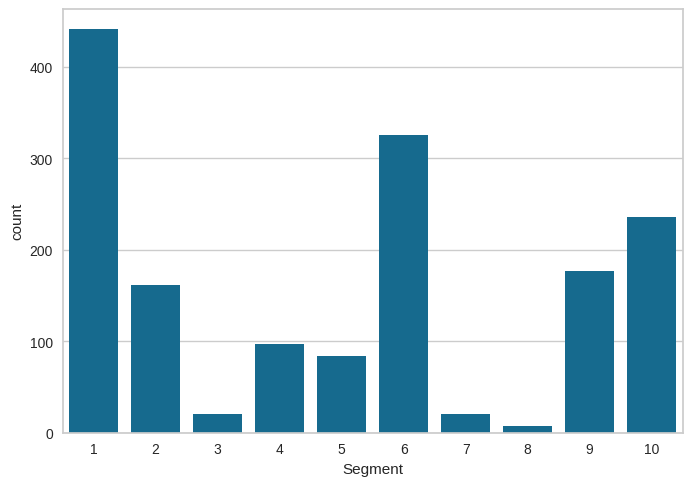

In [78]:
sns.countplot(x='Segment',data=customer_data)

In [79]:
df_merge = pd.merge(customer_data, outTable, on='CustomerID', how='left')
df_merge.head(5)

,CustomerID,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M
0,12346.0,224,2,0.00,-77183.60,77183.6,0.000000,109154.093913,0,1,1,1,111,1,1,1.0,0.500000,NaN
1,12747.0,8,70,2769.40,10.20,199.8,39.562857,42.643523,862,5,4,5,545,10,34,0.0,0.000000,988.11
2,12748.0,0,1944,12872.27,-179.00,400.0,6.621538,15.435534,8092,5,5,5,555,10,1145,14.0,0.065421,14534.29
3,12820.0,225,11,170.46,6.96,19.8,15.496364,4.205490,146,1,1,1,111,1,11,0.0,0.000000,561.53
4,12823.0,26,4,1224.00,229.50,459.0,306.000000,108.187338,160,4,1,4,414,7,1,0.0,0.000000,535.50


In [80]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   CustomerID                 1572 non-null   float64 
 1   Recency                    1572 non-null   int64   
 2   Frequency                  1572 non-null   int64   
 3   Monetary_Sum               1572 non-null   float64 
 4   Monetary_Min               1572 non-null   float64 
 5   Monetary_Max               1572 non-null   float64 
 6   Monetary_Mean              1572 non-null   float64 
 7   Monetary_std               1535 non-null   float64 
 8   Quantity                   1572 non-null   int64   
 9   RecencyScore               1572 non-null   category
 10  FrequencyScore             1572 non-null   category
 11  MonetaryScore              1572 non-null   category
 12  RFM_SCORE                  1572 non-null   object  
 13  Segment                    1572 n

In [81]:
df_merge.isnull().sum()

,0
CustomerID,0
Recency,0
Frequency,0
Monetary_Sum,0
Monetary_Min,0
Monetary_Max,0
Monetary_Mean,0
Monetary_std,37
Quantity,0
RecencyScore,0


In [82]:
df_merge['Total_Sales_3M'] = df_merge['Total_Sales_3M'].fillna(0)

In [83]:
df_merge.dropna(inplace=True)

In [84]:
df_merge.isnull().sum().sum()

np.int64(0)

In [85]:
df_merge.shape

(1535, 18)

In [86]:
corr_matrix = df_merge.corr()
corr_matrix['Total_Sales_3M'].sort_values(ascending=False)

,Total_Sales_3M
Total_Sales_3M,1.000000
Monetary_Sum,0.875037
Quantity,0.615248
Monetary_Mean,0.331497
Cancellation_Frequency,0.273938
MonetaryScore,0.226614
Frequency,0.226581
Unique_Products_Purchased,0.198947
FrequencyScore,0.188200
RFM_SCORE,0.181451


In [87]:
df_merge['Segment'].value_counts()

,count
Segment,
1,404
6,326
10,236
9,177
2,162
4,97
5,84
7,21
3,21


In [88]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)
# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
df_merge['Outlier_Scores'] = model.fit_predict(df_merge.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
df_merge['Is_Outlier'] = [1 if x == -1 else 0 for x in df_merge['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
df_merge.head()

,CustomerID,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M,Outlier_Scores,Is_Outlier
0,12346.0,224,2,0.00,-77183.60,77183.6,0.000000,109154.093913,0,1,1,1,111,1,1,1.0,0.500000,0.00,-1,1
1,12747.0,8,70,2769.40,10.20,199.8,39.562857,42.643523,862,5,4,5,545,10,34,0.0,0.000000,988.11,1,0
2,12748.0,0,1944,12872.27,-179.00,400.0,6.621538,15.435534,8092,5,5,5,555,10,1145,14.0,0.065421,14534.29,-1,1
3,12820.0,225,11,170.46,6.96,19.8,15.496364,4.205490,146,1,1,1,111,1,11,0.0,0.000000,561.53,1,0
4,12823.0,26,4,1224.00,229.50,459.0,306.000000,108.187338,160,4,1,4,414,7,1,0.0,0.000000,535.50,-1,1


In [89]:
outlier_percentage = df_merge['Is_Outlier'].value_counts(normalize=True) * 100
outlier_percentage

,proportion
Is_Outlier,
0,94.983713
1,5.016287


In [90]:
# Separate the outliers for analysis
outliers_data = df_merge[df_merge['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = df_merge[df_merge['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [91]:
customer_data_cleaned.shape[0]

1458

In [92]:
customer_data_cleaned.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Min',
       'Monetary_Max', 'Monetary_Mean', 'Monetary_std', 'Quantity',
       'RecencyScore', 'FrequencyScore', 'MonetaryScore', 'RFM_SCORE',
       'Segment', 'Unique_Products_Purchased', 'Cancellation_Frequency',
       'Cancellation_Rate', 'Total_Sales_3M'],
      dtype='object')

In [93]:
customer_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   CustomerID                 1458 non-null   float64 
 1   Recency                    1458 non-null   int64   
 2   Frequency                  1458 non-null   int64   
 3   Monetary_Sum               1458 non-null   float64 
 4   Monetary_Min               1458 non-null   float64 
 5   Monetary_Max               1458 non-null   float64 
 6   Monetary_Mean              1458 non-null   float64 
 7   Monetary_std               1458 non-null   float64 
 8   Quantity                   1458 non-null   int64   
 9   RecencyScore               1458 non-null   category
 10  FrequencyScore             1458 non-null   category
 11  MonetaryScore              1458 non-null   category
 12  RFM_SCORE                  1458 non-null   object  
 13  Segment                    1458 n

In [94]:
customer_data_cleaned_1=customer_data_cleaned.drop(['CustomerID','RFM_SCORE'],axis=1)

In [95]:
customer_data_cleaned_1.select_dtypes(['int64','float64']).columns


Index(['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Min', 'Monetary_Max',
       'Monetary_Mean', 'Monetary_std', 'Quantity', 'Segment',
       'Unique_Products_Purchased', 'Cancellation_Frequency',
       'Cancellation_Rate', 'Total_Sales_3M'],
      dtype='object')

In [96]:
customer_data_cleaned_1['Segment']=customer_data_cleaned_1['Segment'].astype('category')

In [97]:
cat_columns=customer_data_cleaned_1.select_dtypes(['category']).columns

In [98]:
cat_columns

Index(['RecencyScore', 'FrequencyScore', 'MonetaryScore', 'Segment'], dtype='object')

### Step_6: Prediction model

In [99]:
X=customer_data_cleaned_1.drop(['Total_Sales_3M'],axis=1)
y=customer_data_cleaned_1['Total_Sales_3M']


In [100]:
# Let’s split the data into train, and test sets 0.20 test size
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [101]:
X_train=pd.DataFrame(X_train,columns=X.columns)

In [102]:
X_train.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
254,263,7,106.40,7.80,23.60,15.200000,4.573839,56,1,1,1,1,7,0.0,0.000000
1065,7,562,2933.55,0.39,91.80,5.219840,7.230161,1601,5,5,5,10,334,0.0,0.000000
864,27,54,1712.49,3.75,178.20,31.712778,38.602045,501,4,3,4,9,31,0.0,0.000000
798,11,100,659.73,0.55,40.56,6.597300,6.986272,499,5,4,3,10,98,0.0,0.000000
380,22,100,2725.84,5.04,118.80,27.258400,22.220317,1338,4,4,5,6,84,1.0,0.111111


In [103]:
# Initialize the StandardScaler
scaler_xgb = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['RecencyScore', 'FrequencyScore', 'MonetaryScore','Segment']

# List of columns that need to be scaled
columns_to_scale = X_train.columns.difference(columns_to_exclude)

# Applying the scaler to the necessary columns in the dataset
X_train[columns_to_scale] = scaler_xgb.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler_xgb.transform(X_test[columns_to_scale])

# Display the first few rows of the scaled data
X_train.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
254,1.753566,-0.751715,-0.767934,0.332687,-0.546252,-0.217365,-0.582556,-0.726618,1,1,1,1,-0.890262,-0.660966,-0.498359
1065,-1.084620,4.693842,1.109099,0.217539,0.021825,-0.639815,-0.476470,0.903111,5,5,5,10,4.601863,-0.660966,-0.498359
864,-0.862887,-0.290559,0.298399,0.269752,0.741499,0.481605,0.776430,-0.257214,4,3,4,9,-0.487170,-0.660966,-0.498359
798,-1.040274,0.160784,-0.400561,0.220025,-0.404982,-0.581509,-0.486211,-0.259323,5,4,3,10,0.638128,-0.660966,-0.498359
380,-0.918320,0.160784,0.971194,0.289798,0.246723,0.293055,0.122192,0.625688,4,4,5,6,0.402991,-0.048338,-0.398755


In [104]:
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.10, random_state=1)

In [105]:
xgb  = XGBRegressor(objective='reg:linear',seed=42,early_stopping_rounds=100,eval_metric='rmse',enable_categorical=True)


## Hyperparameters Tuning

In [106]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [107]:
import sklearn
print("Scikit-learn version:", sklearn.__version__)

Scikit-learn version: 1.5.2


Grid 1: Selecting Learning Rate and n_estimators

In [108]:
param_grid1 = {'learning_rate': [0.1,0.03,0.04,0.05],
          'n_estimators':[50,75,90,100,200,500]
         }

xgb_model = xgb
grid1 = GridSearchCV(estimator=xgb_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'neg_mean_absolute_error',refit=True)
grid1.fit(X_train, y_train,eval_set = [(X_val, y_val)],verbose=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[0]	validation_0-rmse:843.85577
[1]	validation_0-rmse:828.80104
[2]	validation_0-rmse:813.94191
[3]	validation_0-rmse:800.17093
[4]	validation_0-rmse:786.73239
[5]	validation_0-rmse:775.65221
[6]	validation_0-rmse:764.17803
[7]	validation_0-rmse:756.73556
[8]	validation_0-rmse:748.05690
[9]	validation_0-rmse:740.85535
[10]	validation_0-rmse:733.38178
[11]	validation_0-rmse:727.90911
[12]	validation_0-rmse:721.78323
[13]	validation_0-rmse:717.40994
[14]	validation_0-rmse:712.43419
[15]	validation_0-rmse:708.34601
[16]	validation_0-rmse:703.04660
[17]	validation_0-rmse:697.55152
[18]	validation_0-rmse:692.60607
[19]	validation_0-rmse:688.70849
[20]	validation_0-rmse:683.99494
[21]	validation_0-rmse:679.89044
[22]	validation_0-rmse:675.66836
[23]	validation_0-rmse:672.88304
[24]	validation_0-rmse:669.55281
[25]	validation_0-rmse:665.97852
[26]	validation_0-rmse:664.28172
[27]	validation_0-rmse:661.82131
[28]	validation_0-rmse:65

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=100,
                                    enable_categorical=True, eval_metric='rmse',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:linear', ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.03, 0.04, 0.05],
                         'n_estimators': [50, 75, 90, 100, 200, 500]},
             scoring='neg_mean_absolute_error', verbose=1)

In [109]:
grid1.best_params_

{'learning_rate': 0.04, 'n_estimators': 75}

In [110]:
grid1.best_score_

np.float64(-432.43938373793645)

Grid 2: Selecting max depth and subsample


In [111]:
param_grid2 = {'learning_rate': [0.04],
          'n_estimators':[65, 75, 85],
           'subsample': [0.5, 1.0],
          'max_depth': [3, 4, 5,7,10],
         }
xgb_model = xgb
grid2 = GridSearchCV(estimator=xgb_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'neg_mean_absolute_error',refit=True)
grid2.fit(X_train, y_train,eval_set = [(X_val, y_val)],verbose=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[0]	validation_0-rmse:839.80103
[1]	validation_0-rmse:827.82323
[2]	validation_0-rmse:813.32909
[3]	validation_0-rmse:800.38498
[4]	validation_0-rmse:787.48290
[5]	validation_0-rmse:775.66559
[6]	validation_0-rmse:762.22547
[7]	validation_0-rmse:753.42581
[8]	validation_0-rmse:742.32130
[9]	validation_0-rmse:736.89788
[10]	validation_0-rmse:729.85257
[11]	validation_0-rmse:719.45673
[12]	validation_0-rmse:713.50745
[13]	validation_0-rmse:706.95493
[14]	validation_0-rmse:698.53229
[15]	validation_0-rmse:693.12596
[16]	validation_0-rmse:685.27653
[17]	validation_0-rmse:680.69176
[18]	validation_0-rmse:673.61233
[19]	validation_0-rmse:668.32213
[20]	validation_0-rmse:665.19823
[21]	validation_0-rmse:664.55981
[22]	validation_0-rmse:661.33686
[23]	validation_0-rmse:657.17631
[24]	validation_0-rmse:654.40879
[25]	validation_0-rmse:652.31898
[26]	validation_0-rmse:650.16580
[27]	validation_0-rmse:647.22317
[28]	validation_0-rmse:64

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=100,
                                    enable_categorical=True, eval_metric='rmse',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:linear', ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.04], 'max_depth': [3, 4, 5, 7, 10],
                         'n_estimators': [65, 75, 85],
                         'subsample': [0.5, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [112]:
grid2.best_params_

{'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 65, 'subsample': 0.5}

In [113]:
grid2.best_score_

np.float64(-418.5642781060563)

Grid 3: Selecting another hyperparameters

In [114]:
param_grid3 = {'learning_rate': [0.04],
          'n_estimators':[55,60,65],
           'subsample': [0.5],
          'max_depth': [3],
          'colsample_bytree': [0.5,0.7,0.8]
         }
xgb_model = xgb
grid3 = GridSearchCV(estimator=xgb_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'neg_mean_absolute_error',refit=True)
grid3.fit(X_train, y_train,eval_set = [(X_val, y_val)],verbose=True)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[0]	validation_0-rmse:848.61469
[1]	validation_0-rmse:835.92200
[2]	validation_0-rmse:821.40469
[3]	validation_0-rmse:810.89413
[4]	validation_0-rmse:800.04436
[5]	validation_0-rmse:786.86842
[6]	validation_0-rmse:773.92641
[7]	validation_0-rmse:765.07523
[8]	validation_0-rmse:758.41123
[9]	validation_0-rmse:752.10527
[10]	validation_0-rmse:745.65163
[11]	validation_0-rmse:734.54875
[12]	validation_0-rmse:728.06401
[13]	validation_0-rmse:722.53511
[14]	validation_0-rmse:712.68994
[15]	validation_0-rmse:705.90973
[16]	validation_0-rmse:698.66599
[17]	validation_0-rmse:694.39924
[18]	validation_0-rmse:691.52167
[19]	validation_0-rmse:686.35759
[20]	validation_0-rmse:682.94742
[21]	validation_0-rmse:684.23725
[22]	validation_0-rmse:680.27295
[23]	validation_0-rmse:678.82500
[24]	validation_0-rmse:675.95735
[25]	validation_0-rmse:674.78097
[26]	validation_0-rmse:669.72485
[27]	validation_0-rmse:666.70448
[28]	validation_0-rmse:663

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=100,
                                    enable_categorical=True, eval_metric='rmse',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:linear', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 0.8],
                         'learning_rate': [0.04], 'max_depth': [3],
                         'n_estimators': [55, 60, 65], 'subsample': [0.5]},
             scoring='neg_mean_absolute_error', verbose=1)

In [115]:
grid3.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.04,
 'max_depth': 3,
 'n_estimators': 65,
 'subsample': 0.5}

In [116]:
grid3.best_score_

np.float64(-421.113200294167)

In [117]:
param_grid4 = {'learning_rate': [0.04],
          'n_estimators':[65],#65
           'subsample': [0.5],#0.5
          'max_depth': [3],#3
          'colsample_bytree': [0.8],
          'gamma': [0,1, 3,5, 10],
    'min_child_weight':[0.1,3,5, 10.0],
    'lambda':[0.0,0.1,0.5, 1.0],
    'alpha': [0.0, 0.3,0.5,1.0]
         }
xgb_model = xgb
grid4 = GridSearchCV(estimator=xgb_model, param_grid=param_grid4, n_jobs=-1, cv=3, verbose=1, scoring = 'neg_mean_absolute_error',refit=True)
grid4.fit(X_train, y_train,eval_set = [(X_val, y_val)],verbose=True)

Fitting 3 folds for each of 320 candidates, totalling 960 fits
[0]	validation_0-rmse:842.73718
[1]	validation_0-rmse:828.62867
[2]	validation_0-rmse:813.41648
[3]	validation_0-rmse:798.72868
[4]	validation_0-rmse:788.60837
[5]	validation_0-rmse:776.73679
[6]	validation_0-rmse:763.64470
[7]	validation_0-rmse:753.71445
[8]	validation_0-rmse:741.27777
[9]	validation_0-rmse:729.59272
[10]	validation_0-rmse:723.76858
[11]	validation_0-rmse:717.81273
[12]	validation_0-rmse:710.84093
[13]	validation_0-rmse:704.09926
[14]	validation_0-rmse:696.30612
[15]	validation_0-rmse:689.04230
[16]	validation_0-rmse:681.69962
[17]	validation_0-rmse:678.76183
[18]	validation_0-rmse:675.01289
[19]	validation_0-rmse:670.93331
[20]	validation_0-rmse:667.23378
[21]	validation_0-rmse:661.44141
[22]	validation_0-rmse:658.04126
[23]	validation_0-rmse:658.22174
[24]	validation_0-rmse:655.64978
[25]	validation_0-rmse:652.54923
[26]	validation_0-rmse:650.67333
[27]	validation_0-rmse:646.49723
[28]	validation_0-rmse:

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=100,
                                    enable_categorical=True, eval_metric='rmse',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    objective='reg:linear', ...),
             n_jobs=-1,
             param_grid={'alpha': [0.0, 0.3, 0.5, 1.0],
                         'colsample_bytree': [0.8], 'gamma': [0, 1, 3, 5, 10],
                         'lambda': [0.0, 0.1, 0.5, 1.0],
                         'learning_rate': [0.04], 'max_depth': [3],
                         'min_child_weight': [0.1, 3, 5, 10.0],
                         'n_estimators': [65], 'subsample': [0.5]},
             scoring='neg_mean_absolute_error', verbose=1)

In [118]:
grid4.best_params_

{'alpha': 0.0,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'lambda': 1.0,
 'learning_rate': 0.04,
 'max_depth': 3,
 'min_child_weight': 10.0,
 'n_estimators': 65,
 'subsample': 0.5}

In [119]:
grid4.best_score_

np.float64(-416.25700043865436)

In [120]:
best_model = grid4.best_estimator_

In [121]:
predictions = best_model.predict(X_test)

In [122]:
train_predictions = best_model.predict(X_train)

In [123]:
train_predictions[:10]

array([321.54218, 983.7609 , 604.94226, 828.6283 , 352.0706 , 794.1009 ,
       371.43988, 179.09837, 774.07324, 366.34933], dtype=float32)

In [124]:
y_train[:10]

,Total_Sales_3M
476,213.07
333,1280.49
235,0.00
1151,0.00
1333,0.00
786,237.93
24,1082.14
440,163.55
859,0.00
1363,0.00


In [125]:
predictions[:10]

array([ 426.55615,  900.2449 ,  173.16908,  676.9658 ,  197.00258,
       2658.9673 ,  241.7851 , 2694.0618 ,  486.78482,  220.97205],
      dtype=float32)

In [126]:
y_test[:10]

,Total_Sales_3M
1320,225.59
836,974.96
413,377.64
522,0.00
1035,0.00
614,7795.62
218,302.57
1031,3277.93
1288,474.16
886,214.60


In [127]:
print('R-Squared for Test set: %0.2f' % r2_score(y_true=y_test, y_pred=predictions))

R-Squared for Test set: 0.59


In [128]:
MSE = np.square(np.subtract(y_test,predictions)).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

581.4312315699132


### Step_8: Shap Value

In [129]:
MSE = np.square(np.subtract(y_train,train_predictions)).mean()
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

676.4559760195742


In [130]:
!pip install shap

In [131]:
import shap

In [132]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Recency                    1458 non-null   int64   
 1   Frequency                  1458 non-null   int64   
 2   Monetary_Sum               1458 non-null   float64 
 3   Monetary_Min               1458 non-null   float64 
 4   Monetary_Max               1458 non-null   float64 
 5   Monetary_Mean              1458 non-null   float64 
 6   Monetary_std               1458 non-null   float64 
 7   Quantity                   1458 non-null   int64   
 8   RecencyScore               1458 non-null   category
 9   FrequencyScore             1458 non-null   category
 10  MonetaryScore              1458 non-null   category
 11  Segment                    1458 non-null   category
 12  Unique_Products_Purchased  1458 non-null   int64   
 13  Cancellation_Frequency     1458 n

In [133]:
#X['Monetary_Max'] = X['Monetary_Max'].apply(lambda x: round(x, 2))

In [134]:
#cat_columns=X.select_dtypes(['category']).columns

In [135]:
#cat_columns

In [136]:
#X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

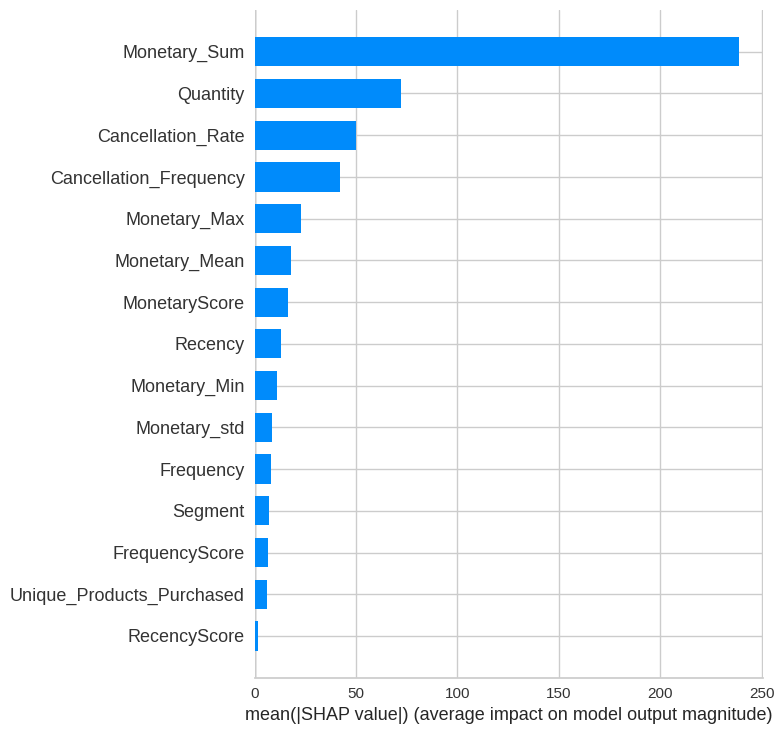

In [137]:
# Initialize the SHAP explainer
explainer = shap.Explainer(best_model)

# Calculate SHAP values for all instances
shap_values = explainer(X_test)

# Visualize global feature importance using summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

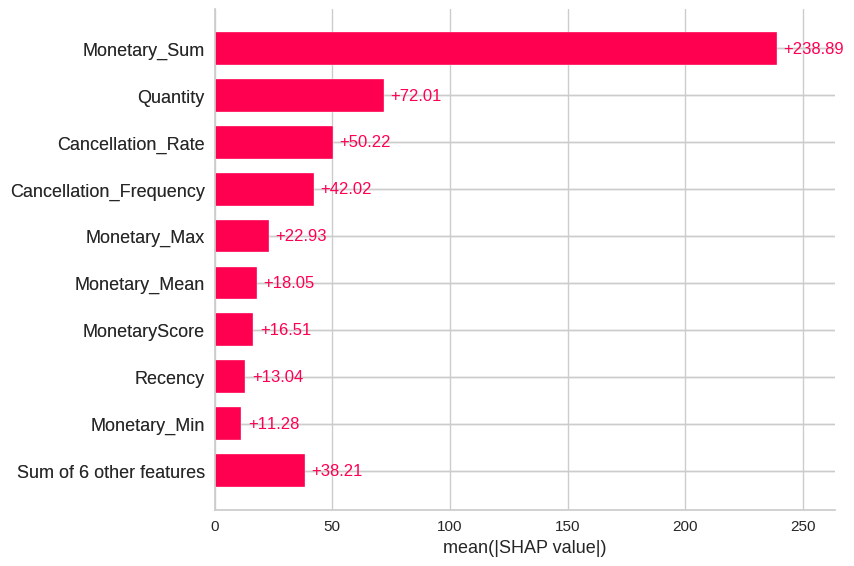

In [138]:
shap.plots.bar(shap_values)

In [139]:
# load JS visualization code to notebook
shap.initjs()

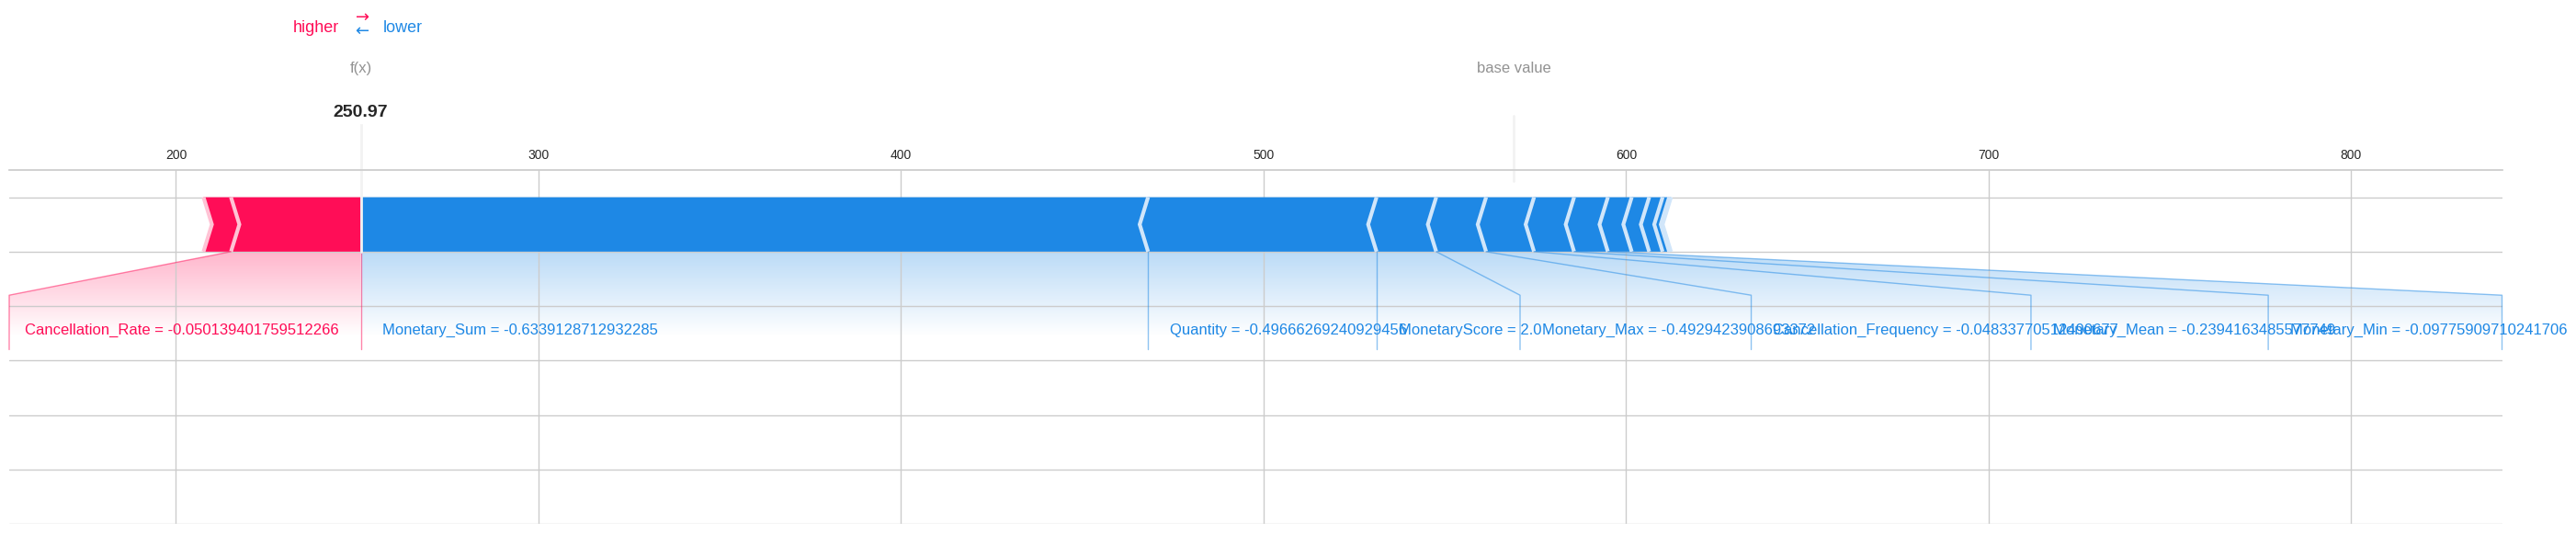

In [140]:
shap.plots.force(shap_values[218], matplotlib=True,figsize=(35,5))

In [141]:
y[476]

np.float64(213.07)

# PCA& K-means Clustering

**We will make the following steps**

    Data pre-processing for K-Means clustering
    Building PCA & K-Means clustering algorithms
    The metrics used to evaluate the performance of a clustering model


In [142]:
customer_data_cleaned_1.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M
0,8,70,2769.40,10.20,199.80,39.562857,42.643523,862,5,4,5,10,34,0.0,0.000000,988.11
1,225,11,170.46,6.96,19.80,15.496364,4.205490,146,1,1,1,1,11,0.0,0.000000,561.53
2,67,59,812.02,-3.30,30.00,13.763051,6.556498,717,3,3,3,5,50,1.0,1.000000,513.50
3,221,12,253.05,-39.95,79.90,21.087500,27.770186,375,1,1,1,1,9,1.0,0.333333,0.00
4,36,125,2112.53,1.25,84.15,16.900240,13.611983,858,4,4,4,6,110,0.0,0.000000,497.83


### Feature Scaling


In [143]:
# Initialize the StandardScaler
scaler_kmeans = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['RecencyScore', 'FrequencyScore', 'MonetaryScore','Segment']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned_1.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned_1.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler_kmeans.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M
0,-1.069426,-0.142030,0.995701,0.389251,0.966213,0.853665,0.862011,0.123278,5,4,5,10,-0.436785,-0.633707,-0.494039,0.451525
1,1.327543,-0.712020,-0.731552,0.336237,-0.600974,-0.209250,-0.560047,-0.635985,1,1,1,1,-0.811660,-0.633707,-0.494039,-0.014961
2,-0.417715,-0.248300,-0.305172,0.168360,-0.512167,-0.285803,-0.473069,-0.030483,3,3,3,5,-0.176002,-0.062313,0.390349,-0.067484
3,1.283360,-0.702359,-0.676662,-0.431318,-0.077707,0.037687,0.311756,-0.393148,1,1,1,1,-0.844258,-0.062313,-0.199243,-0.629021
4,-0.760140,0.389316,0.559146,0.242809,-0.040704,-0.147247,-0.212043,0.119037,4,4,4,6,0.801934,-0.633707,-0.494039,-0.084620


### Run PCA on the dataset:

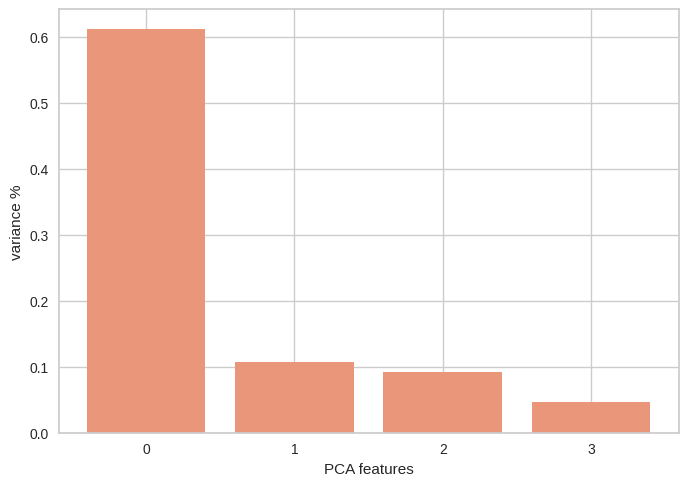

In [144]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(customer_data_scaled)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='darksalmon')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

In [145]:
PCA_components

,0,1,2,3
0,5.670604,2.128321,0.702776,-1.342652
1,-5.564011,0.144652,-0.222484,0.181792
2,0.006084,0.153963,-0.675097,0.390237
3,-5.403893,0.134422,0.849152,0.707783
4,1.968901,-0.305791,-0.643325,-1.206518
...,...,...,...,...
1453,5.767724,0.840537,-0.526377,2.962504
1454,-5.095288,0.023734,2.004807,-0.567899
1455,2.426980,-1.794212,-0.175433,0.020363
1456,-5.614319,0.181229,0.347102,0.742734


In [146]:
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

In [147]:
pc_df

,PC1,PC2,PC3,PC4
Recency,-0.216521,-0.092751,0.009516,-0.006336
Frequency,0.146411,-0.348344,-0.094687,-0.109644
Monetary_Sum,0.167038,-0.261986,0.193966,-0.127490
Monetary_Min,-0.039419,0.075397,-0.267924,-0.291811
Monetary_Max,0.067158,0.028758,0.489375,-0.114816
Monetary_Mean,0.019151,0.173913,0.423744,-0.240193
Monetary_std,0.023202,0.126312,0.533300,-0.022464
Quantity,0.157603,-0.238586,0.167744,-0.165663
RecencyScore,0.313329,0.161280,-0.027920,0.032951
FrequencyScore,0.243214,-0.388954,-0.179642,-0.156677


In [148]:
# Assuming loadings is a pandas DataFrame with PCA loadings as given above
import pandas as pd

# Set a threshold for which features to extract
threshold = 0.25

# Find features with loadings above the threshold for each principal component
important_features = {}
for column in pc_df.columns:
    important_features[column] = pc_df.index[pc_df[column].abs() > threshold].tolist()

# Now 'important_features' dictionary contains the important features for each PC
for pc, features in important_features.items():
    print(f"{pc}: {', '.join(features)}")

PC1: RecencyScore, MonetaryScore, Segment
PC2: Frequency, Monetary_Sum, FrequencyScore, MonetaryScore, Segment, Unique_Products_Purchased
PC3: Monetary_Min, Monetary_Max, Monetary_Mean, Monetary_std
PC4: Monetary_Min, Cancellation_Frequency, Cancellation_Rate


### Build Kmeans model

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a0cc319bba0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


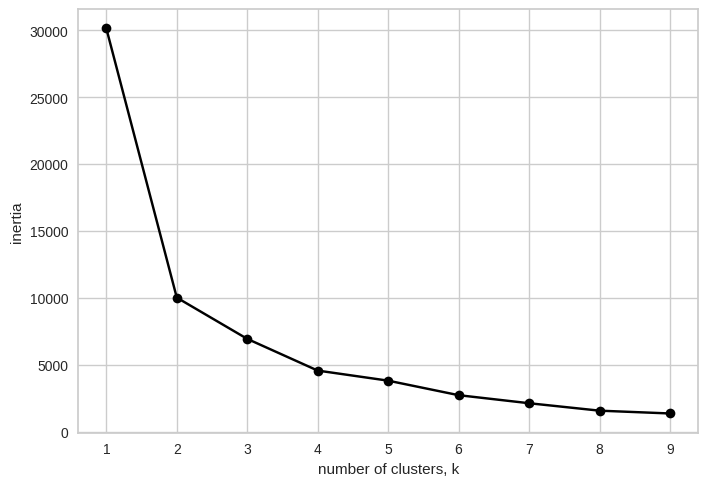

In [149]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Calculate the silhouette score

In [150]:
model = KMeans(n_clusters=3)
model.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'))

0.4937376668677778


In [151]:
pred = model.predict(PCA_components.iloc[:,:2])

In [152]:
customer_data_cleaned_1['cluster'] = pred

In [153]:
customer_data_cleaned_1.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M,cluster
0,8,70,2769.40,10.20,199.80,39.562857,42.643523,862,5,4,5,10,34,0.0,0.000000,988.11,0
1,225,11,170.46,6.96,19.80,15.496364,4.205490,146,1,1,1,1,11,0.0,0.000000,561.53,1
2,67,59,812.02,-3.30,30.00,13.763051,6.556498,717,3,3,3,5,50,1.0,1.000000,513.50,2
3,221,12,253.05,-39.95,79.90,21.087500,27.770186,375,1,1,1,1,9,1.0,0.333333,0.00,1
4,36,125,2112.53,1.25,84.15,16.900240,13.611983,858,4,4,4,6,110,0.0,0.000000,497.83,2


In [154]:
customer_data_cleaned_1['cluster'].value_counts()

,count
cluster,
1,646
2,529
0,283


In [155]:
avg_df = customer_data_cleaned_1.groupby(['cluster'], as_index=False).mean(numeric_only=True)
avg_df.head()

,cluster,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M
0,0,14.229682,215.879859,3434.675548,-36.128092,143.882155,21.209725,22.556142,2023.265018,132.897527,2.766784,1.476804,1513.812933
1,1,191.139319,30.679567,397.268359,-4.205248,58.381625,18.252573,16.158109,219.164087,27.543344,0.425697,0.199732,204.349924
2,2,47.862004,80.495274,1181.027127,-12.991853,96.547940,22.132224,21.514668,705.357278,62.837429,1.056711,0.505689,525.971323


<Axes: xlabel='cluster', ylabel='Cancellation_Frequency'>

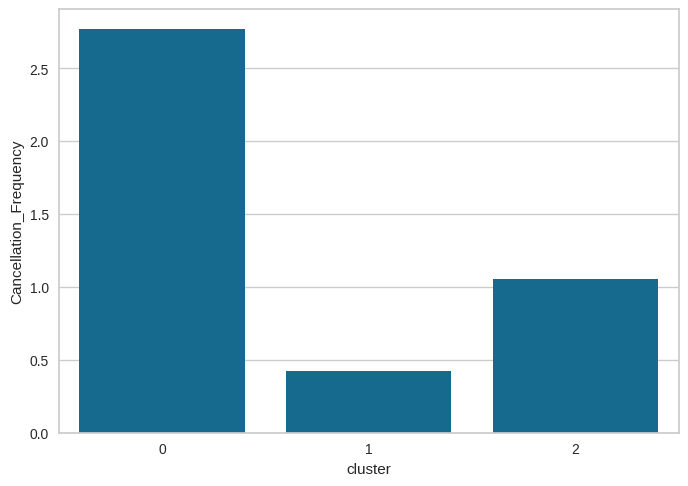

In [156]:
sns.barplot(x='cluster',y='Cancellation_Frequency',data=avg_df)

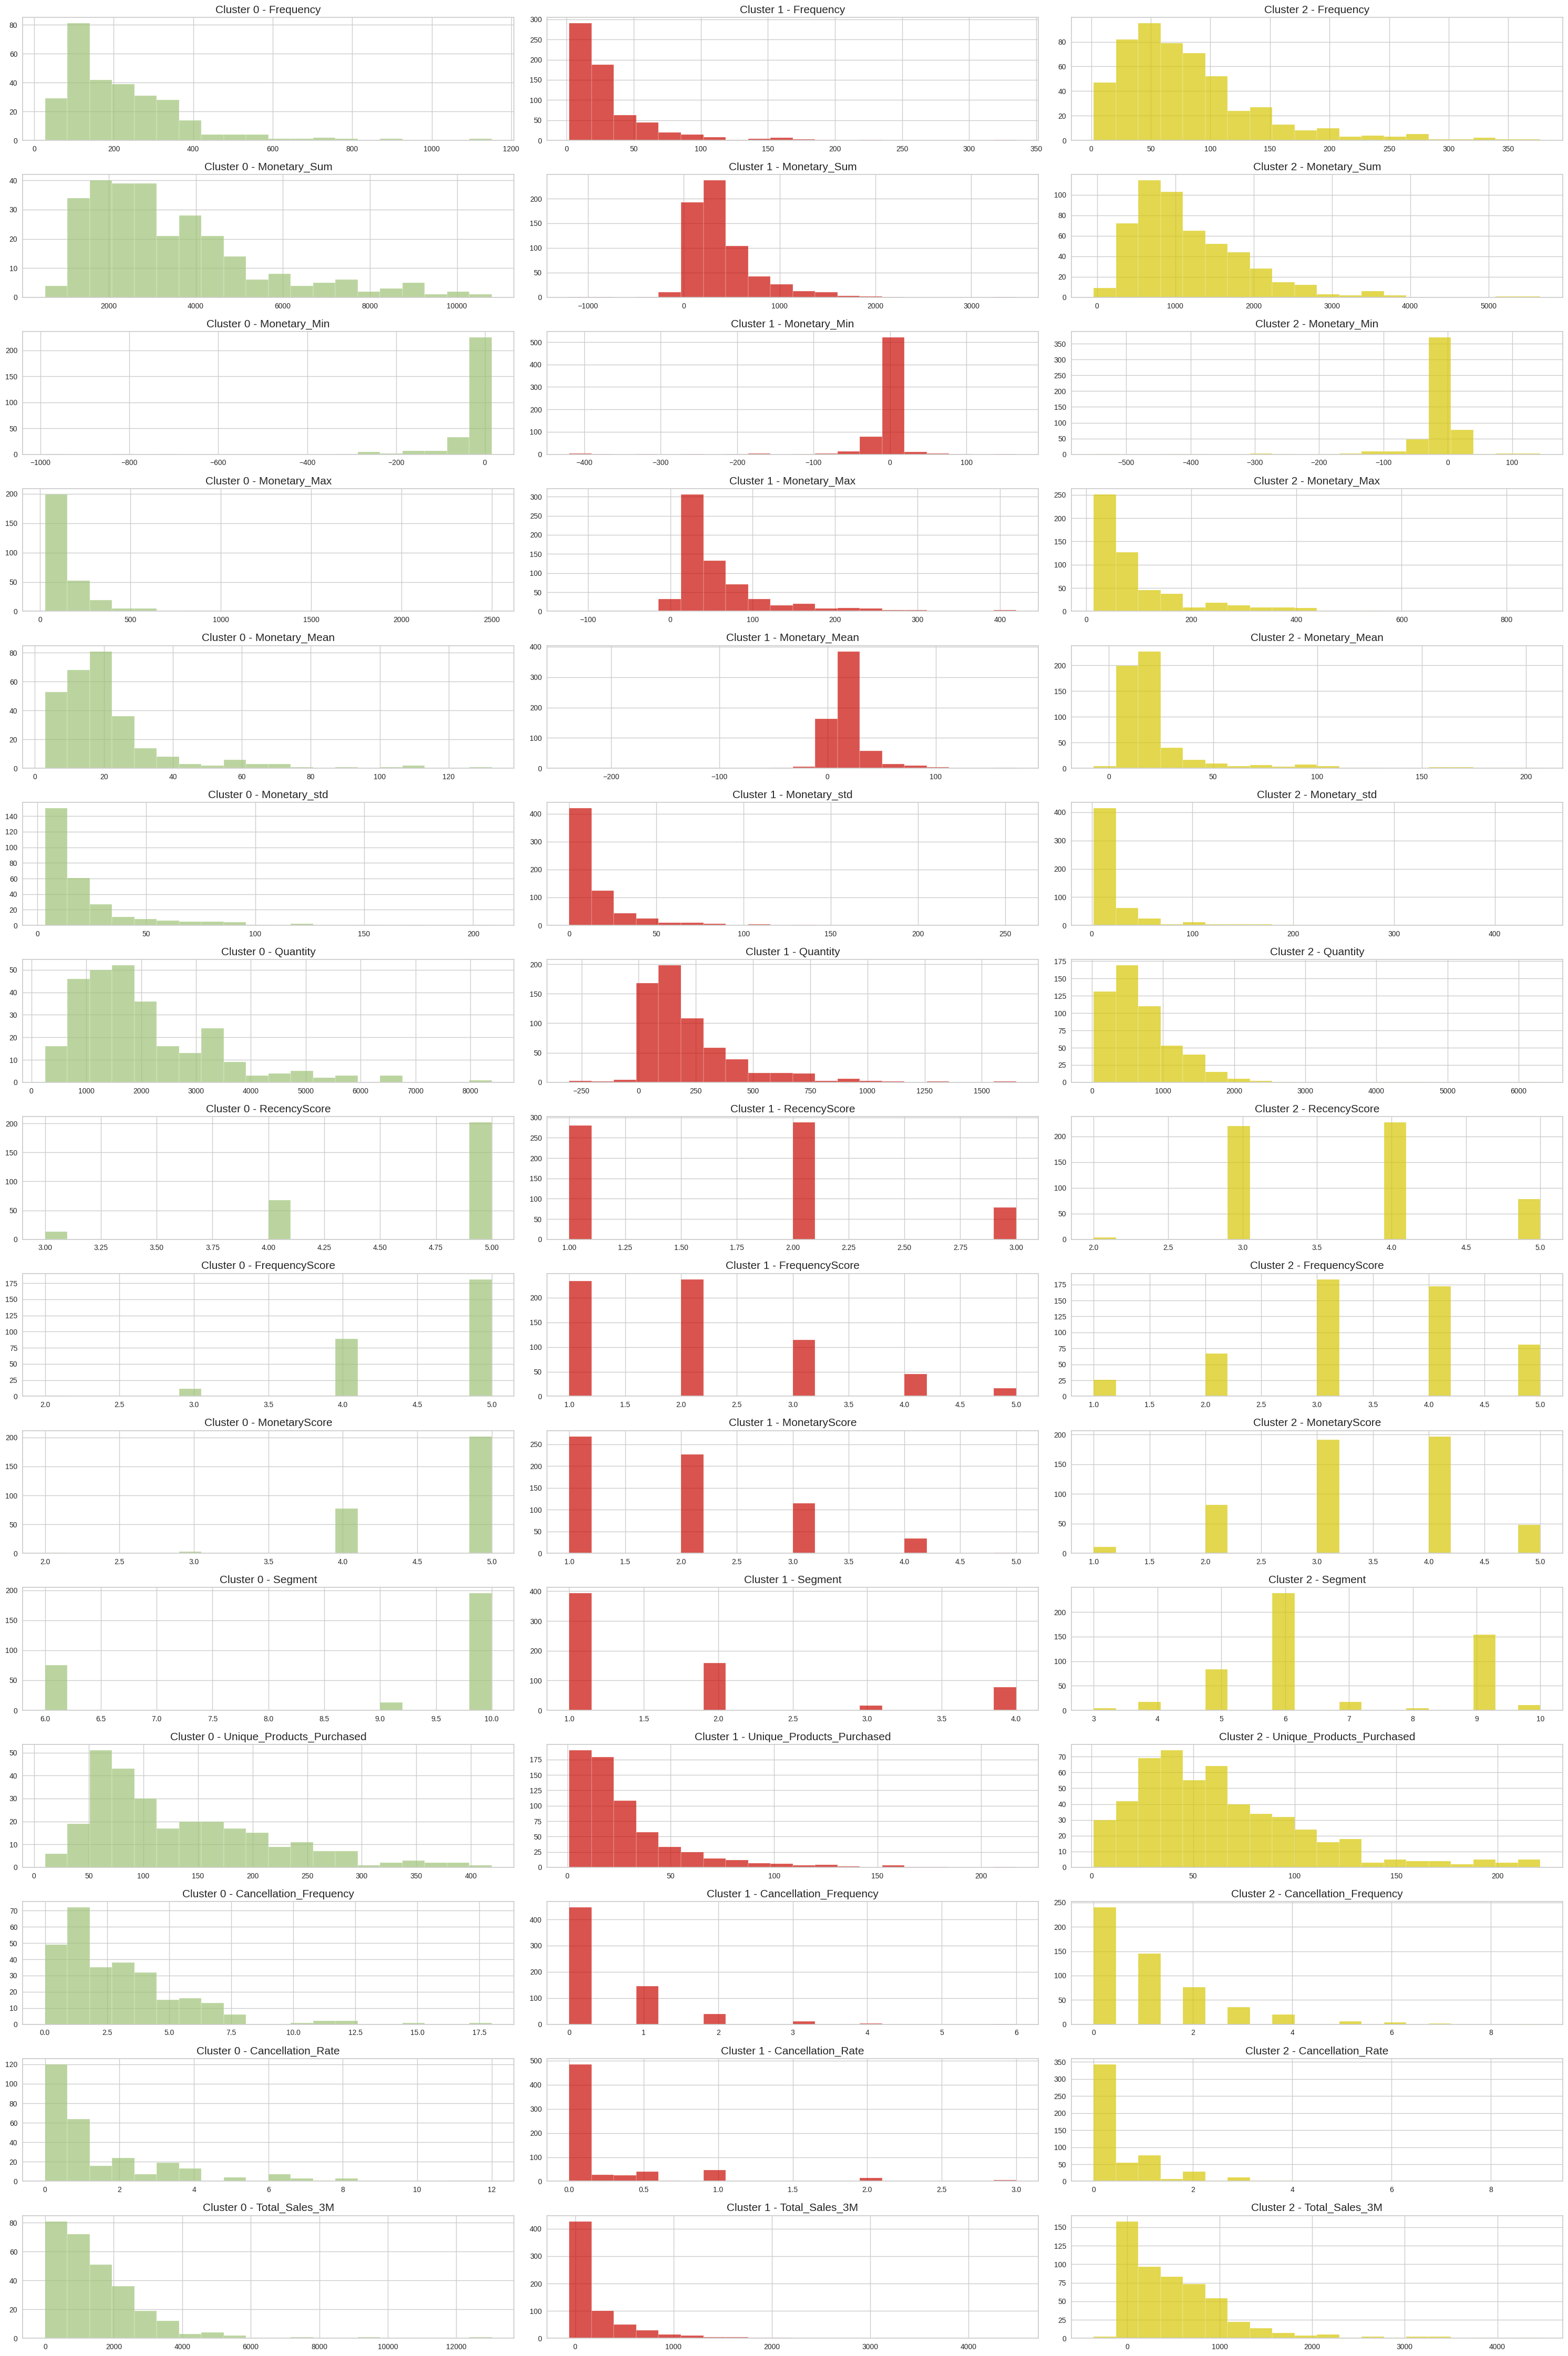

In [157]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned_1.columns[1:-1]
clusters = customer_data_cleaned_1['cluster'].unique()
clusters.sort()
colors = ['g', 'r', 'y']
# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned_1[customer_data_cleaned_1['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [158]:
df2 = pd.DataFrame(customer_data_cleaned_1.groupby(['cluster','Segment'])['Segment'].count())
df2[df2['Segment']>0]

Segment
cluster Segment         
0       6             75
        9             13
        10           195
1       1            393
        2            159
        3             16
        4             78
2       3              4
        4             17
        5             84
        6            238
        7             17
        8              4
        9            154
        10            11

# Dump our models

In [159]:
import pickle

In [160]:
pickle.dump(scaler_xgb, open('scaler_xgb.pickle', 'wb'))

In [161]:
pickle.dump(best_model, open('best_model.pickle', 'wb'))

In [162]:
pickle.dump(scaler_kmeans, open('scaler_kmeans.pickle', 'wb'))

In [163]:
pickle.dump(pca, open('pca.pickle', 'wb'))

In [164]:
pickle.dump(model, open('model.pickle', 'wb'))

In [165]:
import joblib
ex_filename = 'explainer.bz2'
joblib.dump(explainer, filename=ex_filename, compress=('bz2', 9))

['explainer.bz2']

In [166]:
scaler_xgb=pickle.load(open('scaler_xgb.pickle', 'rb'))

In [167]:
best_model=pickle.load(open('best_model.pickle', 'rb'))

In [168]:
scaler_kmeans=pickle.load(open('scaler_kmeans.pickle', 'rb'))

In [169]:
pca=pickle.load(open('pca.pickle', 'rb'))

In [170]:
model=pickle.load(open('model.pickle', 'rb'))

# Test models

In [171]:
cus_id=customer_data_cleaned_1.iloc[476,:]

In [172]:
cus_id=pd.DataFrame(cus_id).T

In [173]:
cus_id

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M,cluster
476,62.0,90.0,646.64,1.7,22.5,7.184889,3.998078,280.0,3.0,4.0,3.0,6.0,70.0,0.0,0.0,213.07,2.0


In [174]:
cus_id=cus_id.drop(['cluster'],axis=1)

In [175]:
cus_id=cus_id.drop(['Total_Sales_3M'],axis=1)

In [176]:


# List of columns that don't need to be scaled
columns_to_exclude = ['RecencyScore', 'FrequencyScore', 'MonetaryScore','Segment']

# List of columns that need to be scaled
columns_to_scale = cus_id.columns.difference(columns_to_exclude)

# Applying the scaler to the necessary columns in the dataset
cus_id[columns_to_scale] = scaler_xgb.transform(cus_id[columns_to_scale])

# Display the first few rows of the scaled data
cus_id.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
476,-0.474854,0.062666,-0.409252,0.237896,-0.555414,-0.556637,-0.60555,-0.490334,3.0,4.0,3.0,6.0,0.167854,-0.660966,-0.498359


In [177]:

result = best_model.predict(cus_id)
result

array([327.0119], dtype=float32)

In [178]:
cus_id=customer_data_cleaned_1.iloc[476,:]

In [179]:
cus_id=pd.DataFrame(cus_id).T

In [180]:
cus_id

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M,cluster
476,62.0,90.0,646.64,1.7,22.5,7.184889,3.998078,280.0,3.0,4.0,3.0,6.0,70.0,0.0,0.0,213.07,2.0


In [181]:
cus_id=cus_id.drop(['cluster'],axis=1)

In [182]:
# List of columns that don't need to be scaled
columns_to_exclude = ['RecencyScore', 'FrequencyScore', 'MonetaryScore','Segment']

# List of columns that need to be scaled
columns_to_scale = cus_id.columns.difference(columns_to_exclude)

# Applying the scaler to the necessary columns in the dataset
cus_id[columns_to_scale] = scaler_kmeans.transform(cus_id[columns_to_scale])

# Display the first few rows of the scaled data
cus_id.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate,Total_Sales_3M
476,-0.472945,0.051187,-0.415083,0.250172,-0.577466,-0.576333,-0.56772,-0.493888,3.0,4.0,3.0,6.0,0.149977,-0.633707,-0.494039,-0.396019


In [183]:
df_segm_pca = pca.transform(cus_id)
segm_kmeans_pca = model.predict(df_segm_pca[:,:2])

In [184]:
segm_kmeans_pca[0]

np.int32(2)

########

In [185]:
cus_id=customer_data_cleaned_1.iloc[[218]]

In [186]:
cus_id.T

,218
Recency,21.000000
Frequency,42.000000
Monetary_Sum,639.050000
Monetary_Min,-7.500000
Monetary_Max,34.000000
Monetary_Mean,15.215476
Monetary_std,6.194160
Quantity,333.000000
RecencyScore,4.000000
FrequencyScore,3.000000


In [187]:
cus_id.drop(['cluster'],axis=1,inplace=True)

In [188]:
cus_id.drop(['Total_Sales_3M'],axis=1,inplace=True)

In [189]:
cus_id

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
218,21,42,639.05,-7.5,34.0,15.215476,6.19416,333,4,3,3,9,36,1.0,0.2


In [190]:
# List of columns that don't need to be scaled
columns_to_exclude = ['RecencyScore', 'FrequencyScore', 'MonetaryScore','Segment']

# List of columns that need to be scaled
columns_to_scale = cus_id.columns.difference(columns_to_exclude)

# Applying the scaler to the necessary columns in the dataset
cus_id[columns_to_scale] = scaler_xgb.transform(cus_id[columns_to_scale])

# Display the first few rows of the scaled data
cus_id.head()

,Recency,Frequency,Monetary_Sum,Monetary_Min,Monetary_Max,Monetary_Mean,Monetary_std,Quantity,RecencyScore,FrequencyScore,MonetaryScore,Segment,Unique_Products_Purchased,Cancellation_Frequency,Cancellation_Rate
218,-0.929407,-0.408301,-0.414291,0.094932,-0.459624,-0.21671,-0.517845,-0.434427,4,3,3,9,-0.403193,-0.048338,-0.319071


In [191]:
columns=cus_id.columns

In [192]:
# Shap Values
explainer = joblib.load(filename="explainer.bz2")

In [193]:
shap_values2 = explainer.shap_values(cus_id)

In [194]:
shap.initjs()

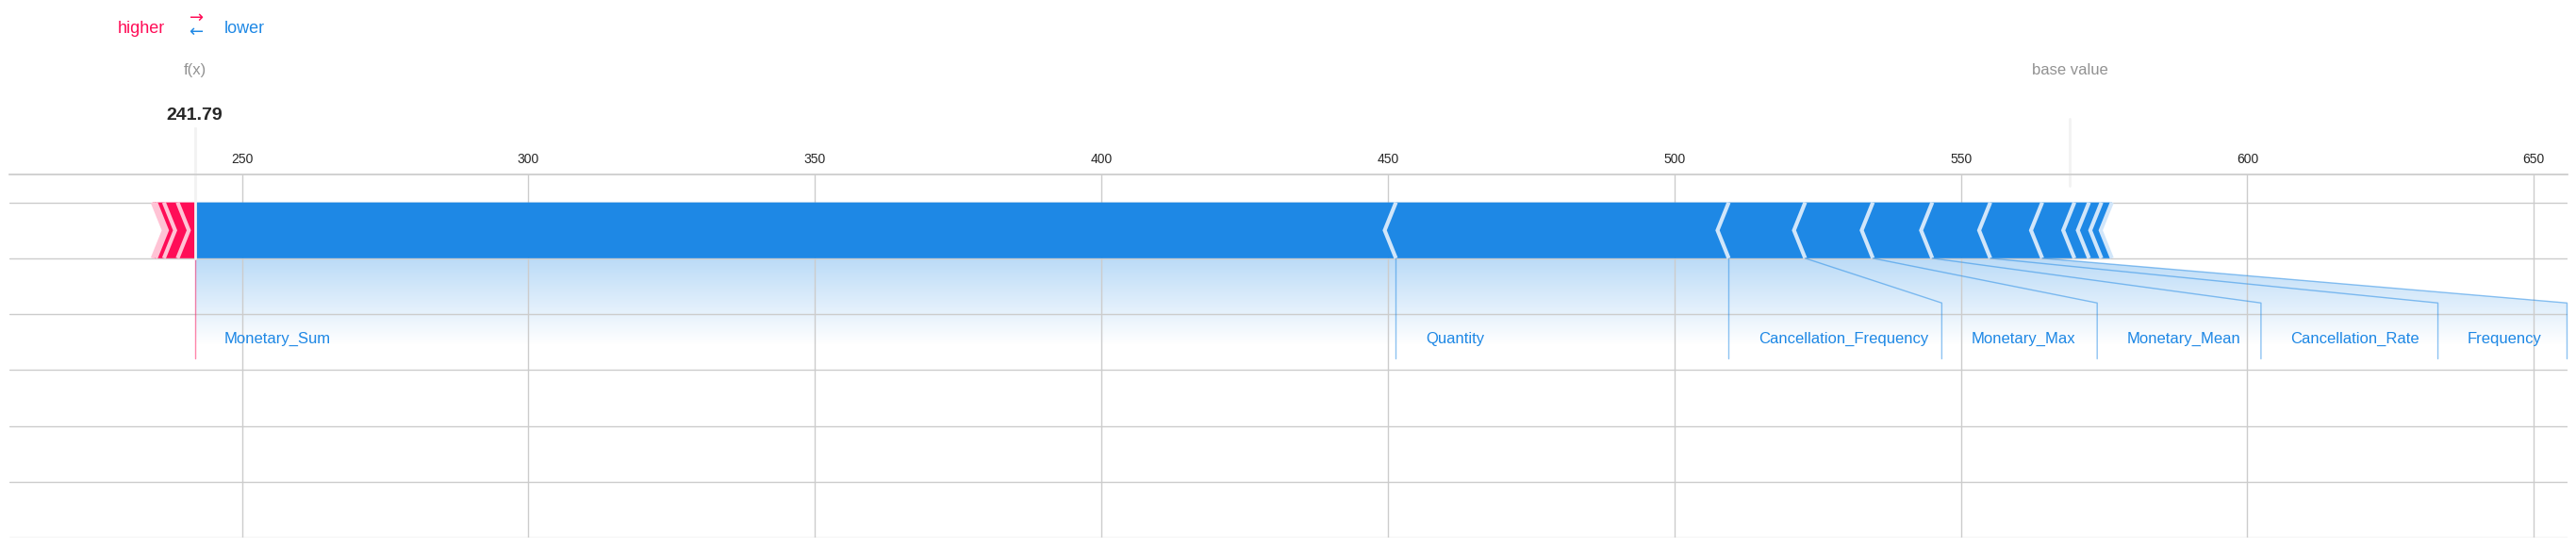

In [195]:
shape_plot =shap.plots.force( explainer.expected_value,shap_values2,columns,matplotlib=True,figsize=(35,5))